# Separating and Using Functions for Analyzing Color-Mag Diagrams
- first one is from division in I band; looking for change in best-fit slope (and/or correlation coefficient)
- different approaches to identifying loops at bright values
    - find peaks in histogram of residuals from best fit line
    - use changes between points in time; identify pos/pos and neg/neg changes, which don't fit redder when brighter relation
        - use number of points in those quadrants and mean distance from y = -x
    - use slopes from best fit lines to every three (or n) points
        - in SuperOrbitalFeatures, just looking for positive slopes is degenerate with other features
- in the middle: two visualization methods to help with loops and other features
    - add arrows

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan
import warnings
warnings.filterwarnings("ignore")

import ogle as o #module


blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [2]:
summ = pd.read_csv('summtab.csv')
cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2
allcross = vstack(cross,cross2)

In [3]:
mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

In [10]:
# from astropy.io import ascii
# ascii.write(vband, 'color_src16.dat', overwrite=True)

In [17]:
def div_cm(srcn,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False,retline=False,printall=False,retflag=False):
    '''Divide color mag by middle of Iint range and fit separately.
    specify fraction of range from faintest point to include in faint piece
    if frac is greater than 1, take it to be number of points rather than fraction of brightness
    retflag: in final return, gives 0 if brightest points not monotonically changing in V-I (in time); 1 if inc; 2 if dec'''
    #get LCs within function 
    if len(interp)==0:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,plot=False,printcorr=printall)
    #add interpolated I to V table
    vband['I int'] = interp
    if frac<1:
        #divide into two using interp range
        irange = np.max(interp)-np.min(interp)
        split = np.max(interp) - irange*frac
        #lower interp
        vbright = vband[vband['I int']<=split]
        vfaint = vband[vband['I int']>=split]
    #if frac is greater than 1, use it to put a number of points into the bright frame
    else:
        #sort by I (lowest (brightest)values first)
        vband.sort('I int')
        vbright = vband[:frac]
        vfaint = vband[frac:]
    #bright half linear best fit
    bmod = np.polyfit(vbright['V mag'] - vbright['I int'],vbright['I int'],1)
    blinmod = (vbright['V mag'] - vbright['I int'])*bmod[0]+bmod[1]
    #faint part
    fmod = np.polyfit(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],1)
    flinmod = (vfaint['V mag'] - vfaint['I int'])*fmod[0]+fmod[1]
    
    #figure out if brightest points have inc,dec, or neither V-I with time
    if retflag:
        #sort bright table by time
        vbright.sort('MJD-50000')
        #add V-I as column for ease
        vbright['V-I'] = vbright['V mag'] - vbright['I int']
        #check if V-I decreasing with time
        if o.non_increasing(vbright['V-I']): flag = 2
        elif o.non_decreasing(vbright['V-I']): flag = 1
        else: flag = 0
        
    if plot: #plot color-mag with two linear best fits
        plt.scatter(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],color='black',s=4)
        plt.scatter(vbright['V mag'] - vbright['I int'],vbright['I int'],color='maroon',s=4)
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.01,mini-.01)
        plt.plot(vfaint['V mag'] - vfaint['I int'],flinmod)
        plt.plot(vbright['V mag'] - vbright['I int'],blinmod)
    if not findcorr:
        if np.abs(fmod[0])>np.abs(bmod[0]) and printall: print('steeper when fainter')
        elif np.abs(fmod[0])<np.abs(bmod[0]) and printall: print('steeper when brighter')
        #list of returns since a few options
        rets = []
        if retline: rets.append(fmod);rets.append(bmod)
        else: rets.append(fmod[0]);rets.append(bmod[0])
        if retflag: rets.append(flag)
        return rets
    #find correlation coefficients as another check
    else:
        fcorr = np.corrcoef(vfaint['V mag']-vfaint['I int'],vfaint['I int'])[1][0]
        bcorr = np.corrcoef(vbright['V mag']-vbright['I int'],vbright['I int'])[1][0]
        return (fcorr**2,fmod[0]),(bcorr**2,bmod[0])

In [5]:
def histpeaks(hist,diff=2,fracdiff=0.1):
    if fracdiff>0:
        #reset diff based on max height in hist
        maxn = np.max(hist[0])
        diff = fracdiff*maxn
    pkinds = []
    pks = []
    maxn = np.max(hist[0])
    c = 0
    for i in hist[0]:
        #first bin
        if c == 0 and i-hist[0][1]>=diff: nbool = True
        #non-boundary bins
        elif c<len(hist[0])-diff and i-hist[0][c+1]>=diff and i-hist[0][c-1]>=diff: nbool = True
        #final bin
        elif c==len(hist[0])-1 and i-hist[0][c-1]>=diff: nbool = True
        else: nbool = False
        if nbool and i>(np.median(hist[0])):
            pkinds.append(c)
            pks.append(i)
        c+=1
    return pks,pkinds

In [6]:
def colorloop(srcn,fracdiff=0.1,diff=2,close=False,iband=[],vband=[],interp=[]):
    '''Identify if there are loop features in Iint vs. V-I plot using hist of residuals from best fit line'''
    if len(iband)<1 and len(vband)<1 and len(interp)<1:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4))

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['I','V','V-I'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    # get bright frac of Iint
    frac = 0.1
    maxi,mini = np.max(interp),np.min(interp)
    cut = maxi - frac*(maxi-mini)
    brighti = color[color['I']<cut]

    #with large range, better to plot residuals from best fit
    mod = np.polyfit(brighti['V-I'],brighti['I'],1)

    #add residuals from linear model of bright values to df
    brighti['res'] = brighti['I'] - (mod[0]*brighti['V-I'] + mod[1])

    if close:#get histogram values but don't plot
        hist = np.histogram(brighti['res'])
    else:
        plt.figure(figsize=(4,3))
        hist = plt.hist(brighti['res'],color='darkseagreen')
        if len(pks)>=2: 
            print('loops')
            plt.text(np.median(hist[1]),np.max(hist[0])-1,'loops')
        else: 
            print('no loops')
            plt.text(np.median(hist[1]),np.max(hist[0])-1,'no loops')
    #identify histogram peaks
    pks,pkinds = histpeaks(hist,fracdiff=fracdiff,diff=diff)
    return pks,pkinds

In [7]:
def colortime(srcn):
    try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
    except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)    
    #make color mag diagram
    interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

    fig, ax1 = plt.subplots(figsize=(12,4))

    im = ax1.scatter(vband['MJD-50000'],vband['V mag']-interp,color='black',marker='x')
    ax1.set_ylabel('V-I')
    # plt.colorbar(im)
    ax2 = ax1.twinx()
    ax2.set_ylabel('I mag', color=pink); ax2.tick_params(axis='y', labelcolor=pink)
    ax2.scatter(iband['MJD-50000'],iband['I mag'],color=pink,alpha=0.3,s=4)
    # ax2.scatter(vband['MJD-50000'],vband['V mag'],color='darkseagreen',alpha=0.3,s=4)
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax2.set_ylim(maxi+.02,mini-.02)

    ax1.set_xlabel('MJD-50000')

In [8]:
def carrow(vband,interp,retvect=False,fs=(6,4)):
    '''Add option to first get LCs and interpolated I'''
    vi = vband['V mag']-interp
    plt.figure(figsize=fs)
    plt.scatter(vi,interp,color=pink)
    #vectors
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    plt.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='darkseagreen',alpha=0.5)
    #flip I mag axis
    maxi,mini = np.max(interp),np.min(interp)
    plt.ylim(maxi+.02,mini-.02)
    plt.ylabel('I mag',fontsize=13)
    plt.xlabel('V-I',fontsize=13)
    if retvect: return xvect,yvect

In [9]:
def colorvec(srcn,frac=0.5,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=False):
    if len(iband)<1 and len(vband)<1 and len(interp)<1: #otherwise uses in iband,vband,interp passed in 
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,plot=False,printcorr=False)
    #plot color mag with arrows
    if plotcm:carrow(vband,interp)
    vi = vband['V mag']-interp
    #make df so that can be filtered to just brighter part of color-mag 
    color = pd.DataFrame(columns=['I','V','V-I'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vi
    maxi,mini = np.max(interp),np.min(interp)
    irange = maxi-mini
    #higher fraction cuts off more
    cut = maxi - frac*irange

    bright = color[color['I']<cut]
    #to also cut out brightest
    # bright = bright[bright['I']>cut2]
    bi = np.array(bright['I'])
    bvi = np.array(bright['V-I'])

    yvect = bi[1:]-bi[:-1]
    xvect = bvi[1:]-bvi[:-1]
    if retearly: return bright,xvect,yvect
    if plotcm: plt.figure(figsize=(5,4))
    if plotquad:
        plt.scatter(xvect,yvect,color='black')
        #dividing quadrants
        plt.axvline(0,color='darkseagreen')
        plt.axhline(0,color='darkseagreen')
        plt.ylabel('I mag change')
        plt.xlabel('V-I mag change')
    #use table to find vectors outside of positive-negative quadrants
    tab = Table({'V-I':xvect,'I mag':yvect})
    #subset of table with both negative
    vineg = tab[tab['V-I']<0]
    neg = vineg[vineg['I mag']<0]
    #subset of table with both positive
    vipos = tab[tab['V-I']>0]
    pos = vipos[vipos['I mag']>0]
    string = f'positive/positive: {len(pos)} \nnegative/negative: {len(neg)}'
    if plottext and plotquad: plt.annotate(string, xy=(0.05, 0.85), xycoords='axes fraction')
    elif printall: print(string)
    #absolute difference from y = -x (checking for points that are barely in this quadrant)
    #changed sum to mean 
    nres = np.mean(np.abs(neg['V-I']+neg['I mag']))
    pres = np.mean(np.abs(pos['V-I']+pos['I mag']))
    string = f'sum of dist from y = -x for pos/pos: {pres:.2f}'
    if plottext and plotquad: plt.annotate(string, xy=(0.15, 0.18), xycoords='axes fraction')
    elif printall: print(string)
    string = f'sum of dist from y = -x for neg/neg: {nres:.2f}'
    if plottext and plotquad: plt.annotate(string, xy=(0.15, 0.12), xycoords='axes fraction')
    elif printall: print(string)
    #returns number of points in two quadrants and mean distance from y = -x
    return len(pos)+len(neg), nres+pres

In [10]:
def colorline(srcn,roll=True,retv=True,hist=True,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=True,plotlc=False,plotbr=False,iband=[],vband=[],interp=[]):
    '''Fit a line to every three points (in time) in color-mag
    roll: (bool) Move one point at a time in fit (if False, divide into threes)
    retv: return vband table and slopes rather than just list of slopes
    hist: plot histogram of slopes
    histcol: color for histogram
    TO DO:  delete option to not use roll OR add functionality to brightness check
            add option to look for loops when bluer when brighter'''
    #get I band, V band, and interpolated I
    if len(iband)<1 and len(vband)<1: #if iband,vband not passed in, get LCs
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=plotlc,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=plotlc,mlist=mlist2)
    if len(interp)<1: interp = o.colormag(iband,vband,retint=True,both=False,plot=plotlc,figsize=(5,4))
    #add interpolated I and V-I to vband table
    vband['I mag'],vband['V-I'] = interp,vband['V mag']-interp
    #loop through in time order and add slopes of best fit to slopes list
    slopes = []
    if roll: loop = np.arange(0,len(vband)-nump)
    #if not roll, don't re-use any points
    else: loop = np.arange(0,len(vband)-nump,nump)
    for v in loop:
        #fit line to point and following two points
        mod = np.polyfit(vband['V-I'][v:v+nump],vband['I mag'][v:v+nump],1)
        #add slope to list of slopes
        slopes.append(mod[0])
    #check whether outlier slopes occur among brightest I band values
    slopes = np.array(slopes)
    #check if redder when brighter (mostly negative slopes)
    if plotbr or printall:
        if len(slopes[slopes<0]) > len(slopes[slopes>0]): 
            #get brightest frac of I band
            maxi, mini = np.max(vband['I mag']),np.min(vband['I mag'])
            #upper bound of I band to be in "bright enough" region
            ub = mini + frac*(maxi-mini) #brightest point + fraction of range
            #get points with positive slopes (or other cutoff)
            pos_slopes = np.where(slopes>cut)
            if printall: print(slopes[pos_slopes])
            #check if those points are at bright I mag
            ifr = vband[pos_slopes]
            imags = ifr['I mag']
            #find number of positive slopes at bright values
            bright = ifr[ifr['I mag']<ub]
            #print the following string for each point at bright values
            if printall: print('turnaround on bright values \n'*len(bright))
            #plot
            if plotbr:
                plt.figure(figsize=(5,3))
                plt.scatter(bright['MJD-50000'],bright['I mag'],c=bright['V-I'],cmap='plasma')
                plt.colorbar(label='V-I')
                plt.ylabel('I mag');plt.xlabel('MJD-50000')
                plt.ylim(np.max(bright['I mag'])+.02,np.min(bright['I mag'])-.02)
    #probably integrate the else above by just having option to SWITCH THE SIGNS
    
    #histogram of slopes
    if hist: plt.figure(figsize=(4,3)); a = sb.distplot(slopes,color=histcol,kde=False); plt.xlabel('color-mag slopes')
    if retv: return vband, slopes
    else: return slopes

In [11]:
srcns = np.concatenate([np.array(cross['src_n']),np.array(cross2['src_n'])])
from matplotlib import colors as mcolors

new function using vectors: plot vectors vs. time to look for loop behavior rather than erratic changes

### residuals as a function of brightness
- perhaps high scatter can be identified by ~even residuals whereas loops have higher residuals at brighter values

In [12]:
def mono_count(bdf,fdf,divide=True,minimum=3,col='residual',useboth=False):
    '''Count how many points in residuals of bright df are following monotonic trends
    generalized by not first identifying peaks
    divide: divide number of monotonic by total number of points
    using decreasing to increasing since I band flipped (even though looks like opposite on plot)'''
    #combine tables if divide False; set same variable name just to bdf if not
    if useboth: df = pd.concat([bdf,fdf])
    else: df = bdf
    #make sure df sorted by time
    df = df.sort_values(by='day')
    #double check that days in order
    if not o.monotonic(df['day']):print('days not in order')
    #try to quantify loopiness by counting how many points before and after peaks are monotonic
    num_mon = 0 #counter for monotonic
    i = 0 #begin with first point
    #number of immediate switches from monotonically increasing to monotonically decreasing
    #decide whether to also test the opposite
    nswitch = 0
    this_inc = False
    #repeat for points after peak
    while i+2 < len(df[col]): 
        sub = 2
        mono = True
        while mono and i+sub<len(df[col]):
            #saves whether or not previous monotonic trend was increasing
            mono,inc = o.monotonic(df[col][i:i+sub],retwhich=True)
            #be careful since I band flipped
            if mono: this_inc = not inc #final inc that's saved is during monotonicity
            sub+=1
        #add to num_mon based on what sub left off on; it automatically gets to 3
        if sub-1>minimum: #minimum 3 passes as long as sub is 4
            #subtracts 3 b/c sub automatically gets there
            num_mon += sub-3 #adds nothing if there aren't monotonic points of at least minimum
            #add to nswitch if this round was not increasing, last round was increasing, and last round is usable (min points) 
            if this_inc: #if it was increasing right before the start
                #look ahead to determine if it switches to monotonic decreasing
                mon,tinc = o.monotonic(df[col][i+sub-2:i+sub+1+(minimum-3)],retwhich=True)
                #put not tinc back in?
                if mon and tinc: #if next three monotonically decreasing, add 1 to number of switches
                    nswitch+=1
        #now reset i to i+sub to start again
        i += sub-2 #adds 1 if no monotonic behavior
    if divide: return num_mon/len(df),nswitch
    return num_mon,nswitch

In [13]:
#bin df from res_brightness
def bindf(bright,npoints=2):
    '''bin df from res_brightness, so columns should be day, I, V-I, and residual'''
    dsplit = np.array_split(bright['day'],len(bright)/npoints)
    newd = []
    for d in dsplit:
        dmean = np.mean(d)
        newd.append(dmean)
    isplit = np.array_split(bright['I'],len(bright)/npoints)
    newi = []
    for i in isplit:
        imean = np.mean(i)
        newi.append(imean)
    visplit = np.array_split(bright['V-I'],len(bright)/npoints)
    newvi = []
    for vi in visplit:
        vimean = np.mean(vi)
        newvi.append(vimean)
    newr = []
    rsplit = np.array_split(bright['residual'],len(bright)/npoints)
    for r in rsplit:
        rmean = np.mean(r)
        newr.append(rmean)
    newdf = pd.DataFrame(columns = ['day','I','V-I','residual'])
    newdf['day'] = newd
    newdf['I'] = newi
    newdf['V-I'] = newvi
    newdf['residual'] = newr
    return newdf

In [14]:
def res_brightness(srcn,frac=0.5,iband=[],vband=[],interp=[],plot=False,plotres=False,plotrestime=False,retswitch=False,printall=True,retdf=False,
                   div=True,retmono=True,retslope=False,retres=False,useboth=False,minmono=3,monocol='residual',binres=1):
    '''Fit line to brightest half and faintest half of points and compare residuals from those lines
    retmono: include fraction of points in residual vs. time of bright part of color-mag that are changing monotonically
    retslope: return difference in slopes of best fit lines to bright and faint parts of I vs. V-I (currently can only do if both retmono and retslope, so change if need be)
    minmono: minimum number of points with monotonic change to be counted
    retres: return mean bright and faint residuals (no absolute values so want it to be higher/around the same at faint)
        - may be useful in tandem with absolute version
    binres: how many points per bin (if 1, do nothing)'''
    if len(iband)<1 and len(vband)<1 and len(interp)<1:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=plot,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=plot,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
        if not plot: plt.close()

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['day','I','V','V-I','residual'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    color['day'] = vband['MJD-50000']
    
    maxi,mini = np.max(interp),np.min(interp)
    #cutoff measured from max (faint), so large frac yields smaller bright frame
    bright = color[color['I']<(maxi-(maxi-mini)*frac)]
    faint = color[color['I']>(maxi-(maxi-mini)*frac)]

    #fit line to I vs. V-I for bright and faint values
    bmod = np.polyfit(bright['V-I'],bright['I'],1)
    fmod = np.polyfit(faint['V-I'],faint['I'],1)
    
    #expected values using linear fit
    expectb = bright['V-I']*bmod[0] + bmod[1]
    expectf = faint['V-I']*fmod[0] + fmod[1]
    
    #find residuals from best fit -- preserve sign
    bright['residual'] = bright['I'] - expectb
    faint['residual'] = faint['I'] - expectf
    
    #check if binres is auto, in which case replace based on number of points in bright
    if binres=='auto':
        binres = int(len(bright)/20)
        if binres==0: binres=1
        if printall: print(f'binning every {binres} points')

    #plot residual vs. I mag
    if plotres:
        plt.figure(figsize=(8,5))
        mind,maxd = np.min(color['day']),np.max(color['day'])
        plt.scatter(bright['I'],bright['residual'],c=bright['day'],cmap='plasma',vmin=mind,vmax=maxd)
        plt.scatter(faint['I'],faint['residual'],c=faint['day'],cmap='plasma',vmin=mind,vmax=maxd)
        plt.colorbar(label='MJD-50000')
        plt.ylabel('I mag - expected I mag',fontsize=13)
        plt.xlabel('I mag',fontsize=13)
        plt.xlim(maxi+.02,mini-.02)
        
    #plot residual vs. time
    if plotrestime:   
        plt.figure(figsize=(8,5))
        plt.scatter(bright['day'],bright['residual'],c=bright['I'],cmap='plasma')
        plt.ylabel('I mag - expected I mag',fontsize=13)
        plt.xlabel('Day')
        plt.colorbar(label='I mag')
        
    #return tables
    if retdf: return bright
    #mean of abs value 
    #changed from sum of squares to make values larger
    bsum = np.mean(np.abs(bright['residual']))
    fsum = np.mean(np.abs(faint['residual']))
    
    #if retres, also calcuate without taking abs value
    if retres:
        or_bmean = np.mean(bright['residual'])
        or_fmean = np.mean(faint['residual'])
    if printall: 
        print(f'faint sum of abs residuals: {fsum}')
        print(f'bright sum of abs residuals: {bsum}')
        
    #fit line to bright residuals vs. I mag
    resmod = np.polyfit(bright['I'],bright['residual'],1)
    fresmod = np.polyfit(faint['I'],faint['residual'],1)
    
    #make list of returns since so  many options
    retlist = [bsum,fsum,resmod[0]-fresmod[0]] #returned no matter what
    if retmono:
        if binres > 1:
            #overwrites tables
            bright = bindf(bright,npoints=binres)
            if useboth: faint = bindf(faint,npoints=binres)
        mono_frac,nswitch = mono_count(bright,faint,divide=div,minimum=minmono,col=monocol,useboth=useboth)
        retlist.append(mono_frac)
        if retswitch:retlist.append(nswitch)
    if retslope:
        retlist.append(bmod[0]-fmod[0])
    if retres: 
        retlist.append(or_bmean)
        retlist.append(or_fmean)
    return retlist

In [64]:
loops

[3, 15, 16, 13, 27, 46, 125, 80, 87, 132, 128, 104]

In [65]:
bright = res_brightness(128,retdf=True)

In [66]:
bright[:3]

day          I       V       V-I  residual
8   3654.69165  15.114112  15.155  0.040888  0.343666
9   3656.71763  15.118964  15.165  0.046036  0.350804
33  4369.69545  14.804059  14.764 -0.040059 -0.002330

(15.2, 14.5)

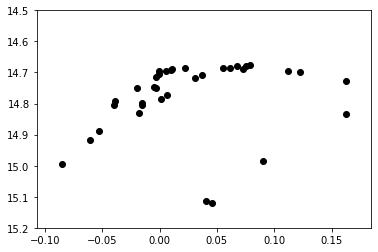

In [69]:
plt.scatter(bright['V-I'],bright['I'],color='black')
plt.ylim(15.2,14.5)

In [73]:
mono_count(bright,[])

(0.5142857142857142, 2)

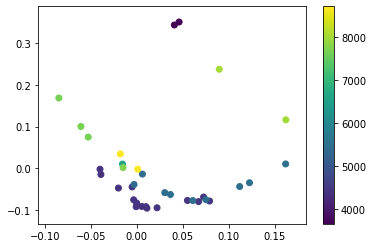

In [71]:
plt.scatter(bright['V-I'],bright['residual'],c=bright['day'])
plt.colorbar()

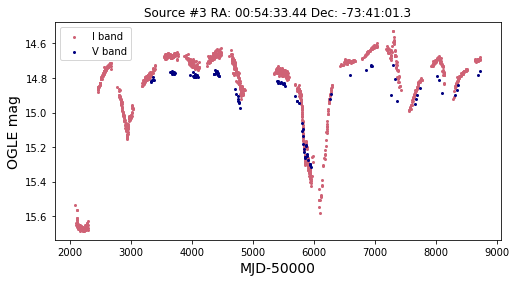

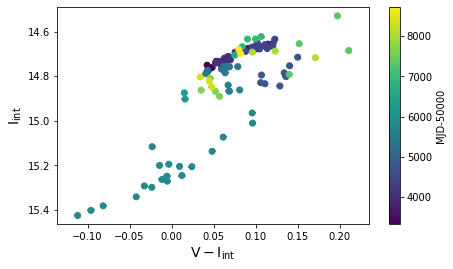

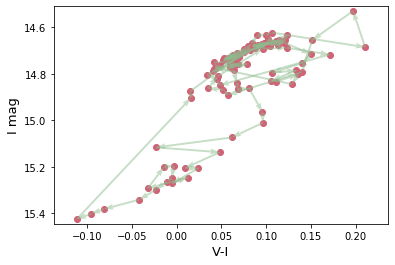

In [18]:
try: iband, vband = o.getIV(3,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(3,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

97,32,62,52? follow up the flat top
complete turnover: 50,106


In [15]:
def cm(s):
    try: iband, vband = o.getIV(s,cross,stack=True,plot=True,mlist=mlist1)
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=True,mlist=mlist2)
    interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

In [20]:
# cm(97)
# cm(32)
# cm(62)
# cm(52)

In [21]:
#for each flattening source, calculate slope in brightest tenth and see if it's representative
print(div_cm(97,frac=0.95,retline=True))
print(div_cm(32,frac=0.95,retline=True)) 
print(div_cm(62,frac=0.95,retline=True))
print(div_cm(52,frac=0.95,retline=True))
#not absolute decrease of slope and brighter int, b/c it's above

(array([-2.19366397, 14.66628337]), array([-0.0916149 , 14.23629758]))
(array([-1.99236106, 15.92068837]), array([-0.39655273, 15.44891126]))
(array([-1.60129193, 14.45529128]), array([ 0.16267306, 14.12644383]))
(array([-2.510941  , 15.09261053]), array([-0.33261376, 14.73957549]))


Text(0.35, 0.1, 'size represents monotonic fraction')

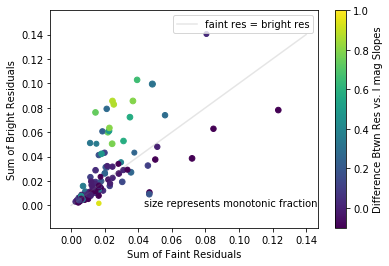

In [23]:
plt.scatter(summ['mean abs faint residual'],summ['mean abs bright residual'],
            c=summ['residual slope diff'],vmin=-.1,vmax=1,s=summ['bright res monotonic frac']*50)
# plt.scatter(ofsum,obsum,marker='v',label='other',c=oslopes,vmin=-.1,vmax=1)
# plt.scatter(lfsum,lbsum,label='loops',c=lslopes,vmin=-.1,vmax=1)
plt.colorbar(label='Difference Btwn Res vs. I mag Slopes')

x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Sum of Bright Residuals')
plt.xlabel('Sum of Faint Residuals')
plt.annotate('size represents monotonic fraction',xy=(0.35,0.1),xycoords='axes fraction')

Text(0.35, 0.1, 'size represents monotnic fraction')

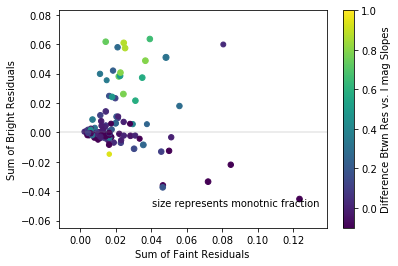

In [24]:
#repeat plot but from faint res = bright res line
plt.scatter(summ['mean abs faint residual'],summ['mean abs bright residual']-summ['mean abs faint residual'],
            c=summ['residual slope diff'],vmin=-.1,vmax=1,s=summ['bright res monotonic frac']*50)
# plt.scatter(ofsum,obsum,marker='v',label='other',c=oslopes,vmin=-.1,vmax=1)
# plt.scatter(lfsum,lbsum,label='loops',c=lslopes,vmin=-.1,vmax=1)
plt.colorbar(label='Difference Btwn Res vs. I mag Slopes')

# x = np.linspace(0,.14)
# plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.axhline(0,color='grey',alpha=0.2)
plt.ylabel('Sum of Bright Residuals')
plt.xlabel('Sum of Faint Residuals')
plt.annotate('size represents monotnic fraction',xy=(0.35,0.1),xycoords='axes fraction')

below: none of the loop sources are in the clump, but a couple actually have higher faint residuals

In [16]:
def sf(file):
    plt.savefig(f'Figs/{file}.png',dpi=150,bbox_inches='tight')

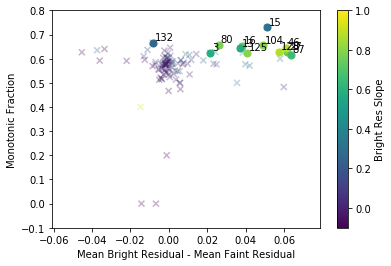

In [27]:
plt.scatter(summ['mean abs bright residual']-summ['mean abs faint residual'],summ['bright res monotonic frac'],alpha=0.3,c=summ['residual slope diff'],vmin=-.1,vmax=1,marker='x',label='all sources')
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['bright res monotonic frac'],c=row['residual slope diff'],s=50,vmin=-.1,vmax=1,marker='o')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['bright res monotonic frac']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Monotonic Fraction')
plt.ylim(-.1,0.8)
sf('mono_res_slope')

additional feature in 132 yields high residuals at faint values; compounded by there being very few loop points
not fully clear that 86 is a loop source
- with arrows, shows there may be loops but complicated/at different values

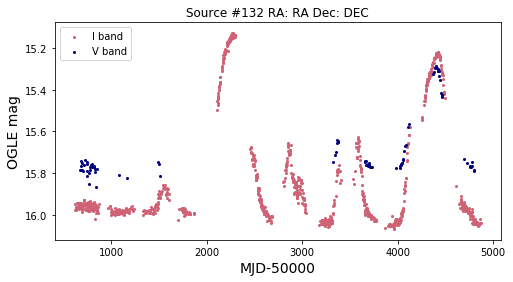

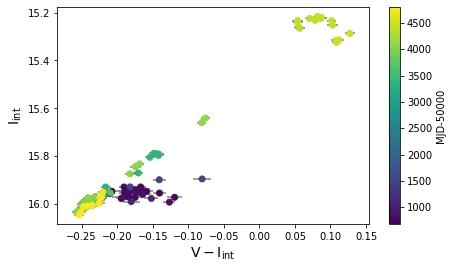

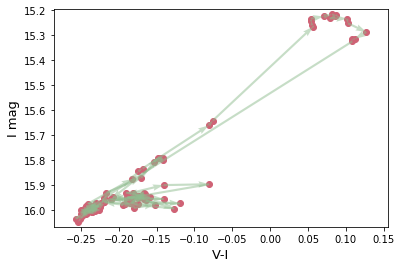

In [152]:
#look at 132 and 86
try: iband, vband = o.getIV(132,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(132,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

carrow(vband,interp,retvect=False,fs=(6,4))

In [456]:
res_brightness(132,retswitch=True)

faint sum of abs residuals: 0.03562645770530561
bright sum of abs residuals: 0.02714489929793385


[0.02714489929793385, 0.03562645770530561, 0.26233868662634635, 0.6, 1]

In [449]:
# try binning for 132
bdf = res_brightness(132,retdf=True,binres=2)

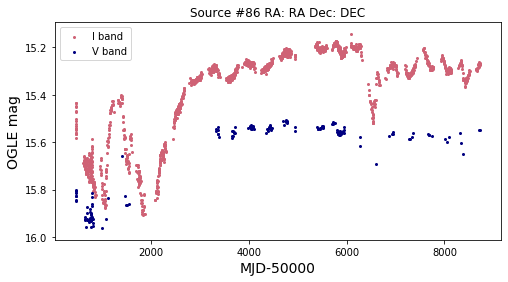

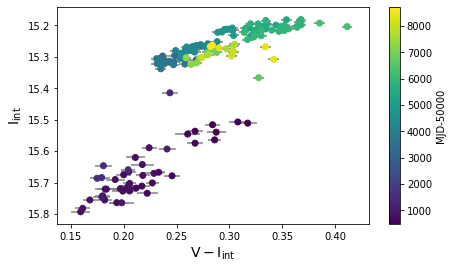

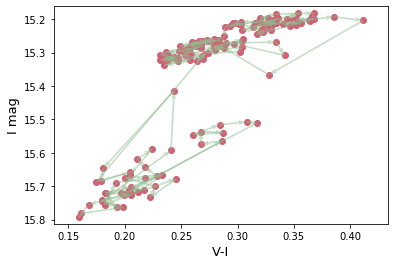

In [25]:
try: iband, vband = o.getIV(86,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(86,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

carrow(vband,interp,retvect=False,fs=(6,4))

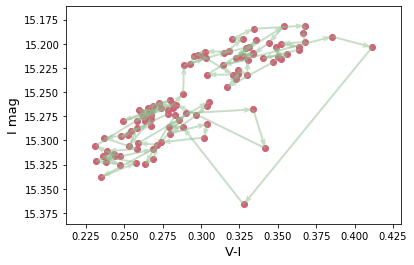

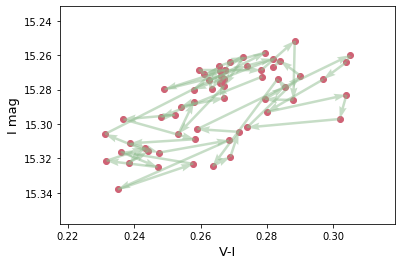

In [29]:
#repeat arrow figure for 86 after zooming in on crowded region
vband['I'] = interp
vband2 = vband[vband['I']<15.4]
carrow(vband2,vband2['I'],retvect=False,fs=(6,4))

#again on bottom part
vb3 = vband2[vband2['I']>15.25]
vb3['V-I'] = vb3['V mag'] - vb3['I']
vb3 = vb3[vb3['V-I']<.31]

carrow(vb3,vb3['I'],retvect=False,fs=(6,4))


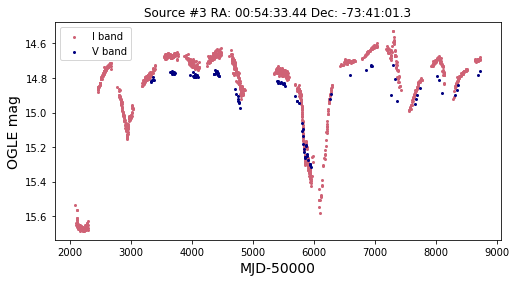

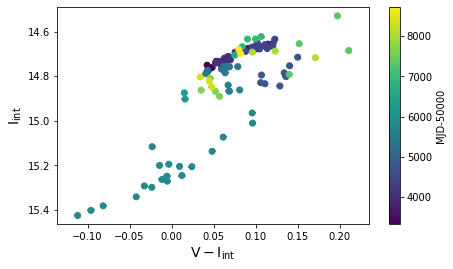

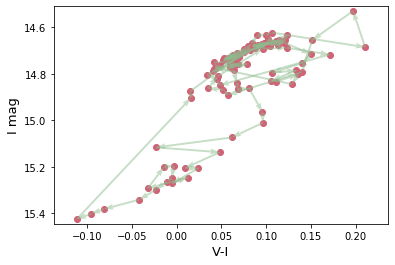

In [30]:
#check 3, which is also a bit of an edge case
#notice similarities in LC with 86
#hence the value of not just keeping final answer, but rather each of these dimensions
try: iband, vband = o.getIV(3,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(3,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

carrow(vband,interp,retvect=False,fs=(6,4))

(-0.1, 0.8)

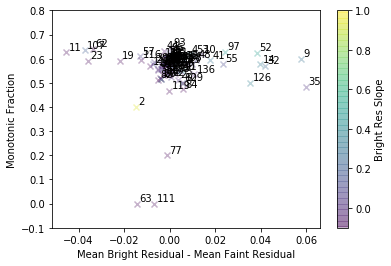

In [42]:
#now check potential false positives
#plot and annotate all sources not in by-eye loop list
for s in srcns:
    if s not in loops:  
        row = summ[summ['src_n']==s]
        plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['bright res monotonic frac'],alpha=0.3,c=row['residual slope diff'],vmin=-.1,vmax=1,marker='x')
        #annotate with source number to make follow-up easier
        plt.annotate(str(s),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['bright res monotonic frac']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Monotonic Fraction')
plt.ylim(-.1,0.8) #use same y limit

In [38]:
#now check potential false positives from above -- 104 should just be added to loop list
# try: iband, vband = o.getIV(104,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(104,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
# plt.xlim(-.3,.4) #taking out outlier
# carrow(vband,interp,retvect=False,fs=(6,4))
# plt.xlim(-.3,.4)

good that 52 (below) is in a similar parameter space, since part of it looks like type 1

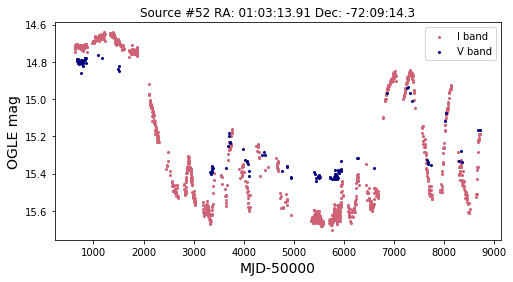

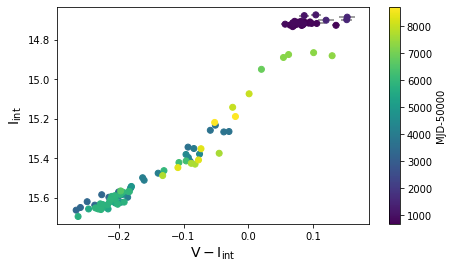

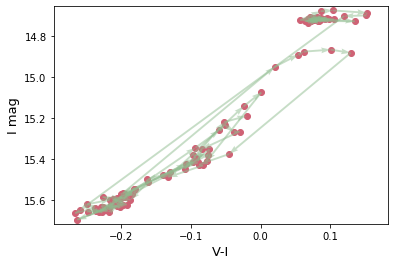

In [44]:
#and the loop happens during type 1
try: iband, vband = o.getIV(52,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(52,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))


In [18]:
loops

[3, 15, 16, 13, 27, 46, 125, 80, 87, 132, 128, 104]

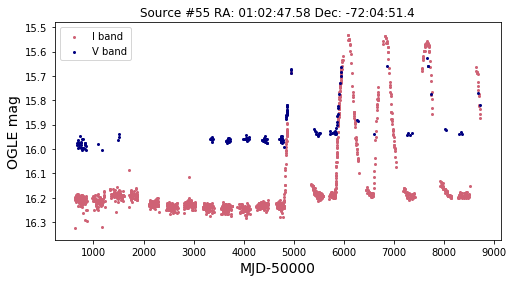

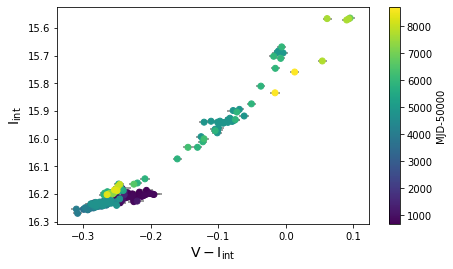

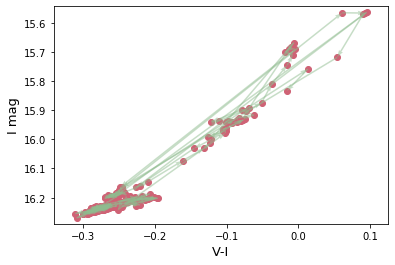

In [47]:
#same with 55: one loop from type 1 region
try: iband, vband = o.getIV(55,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(55,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

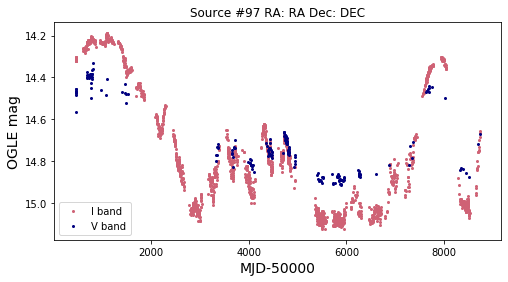

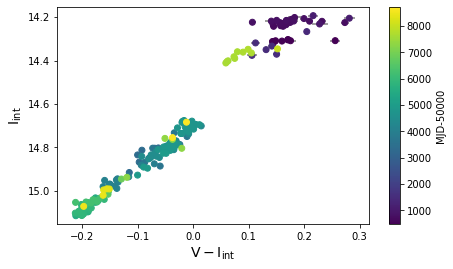

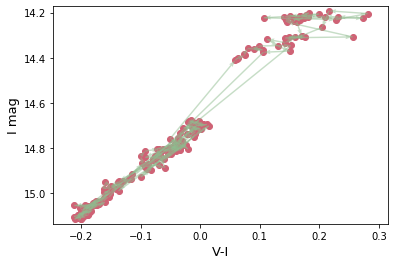

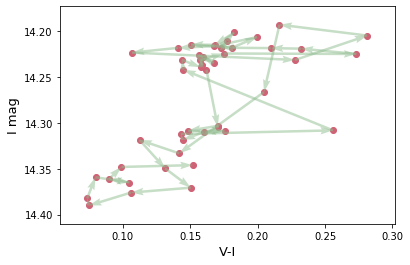

In [49]:
#doesn't have characteristic counter-clockwise but does globally look similar
#potential pattern of flat turnaround with these large flares (see 2 and 52 for e.g.)
try: iband, vband = o.getIV(97,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(97,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

#zoom in on top part to inspect for loops
vband['I'] = interp
vband2 = vband[vband['I']<14.4]
carrow(vband2,vband2['I'],retvect=False,fs=(6,4))

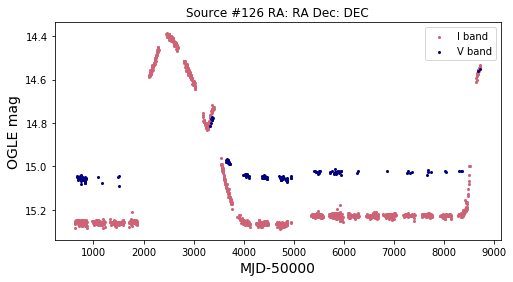

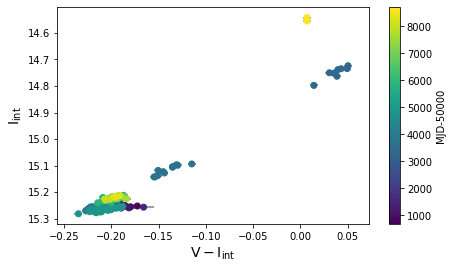

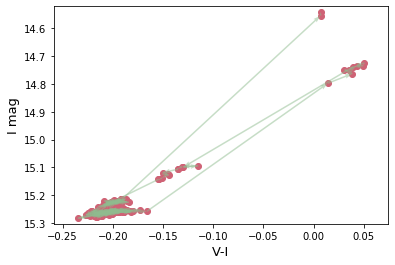

In [50]:
#126 tough b/c could have loop but not enough flare/bright coverage

try: iband, vband = o.getIV(126,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(126,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

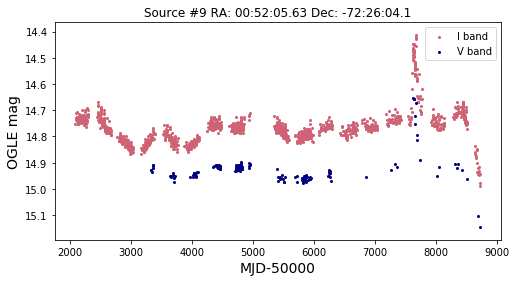

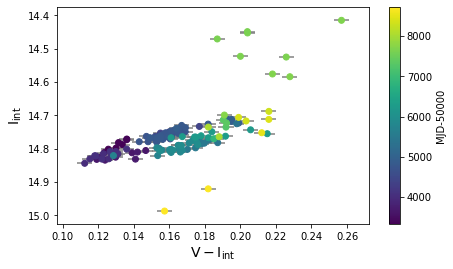

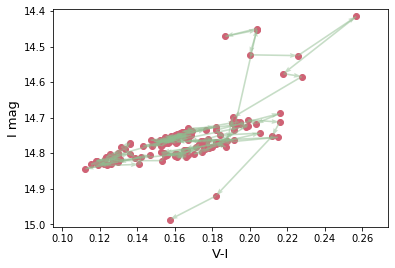

In [51]:
#certainly interesting color-mag but not really loops
try: iband, vband = o.getIV(9,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(9,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

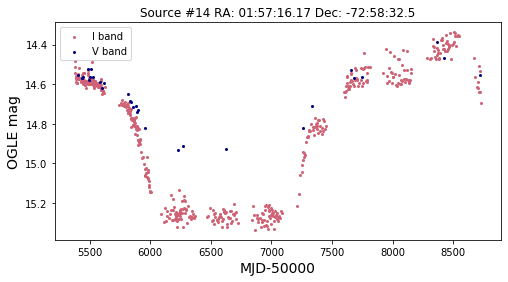

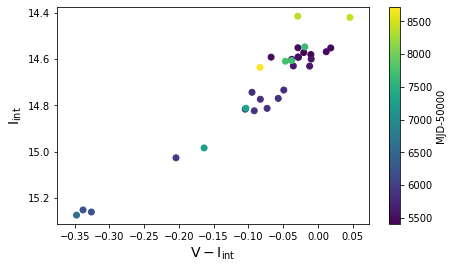

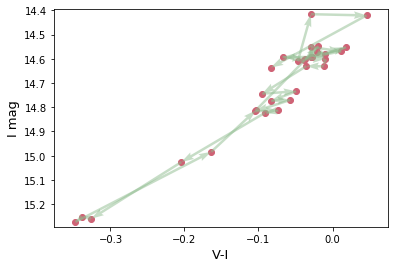

In [53]:
#very low coverage, but slight chance of loopiness
try: iband, vband = o.getIV(14,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(14,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

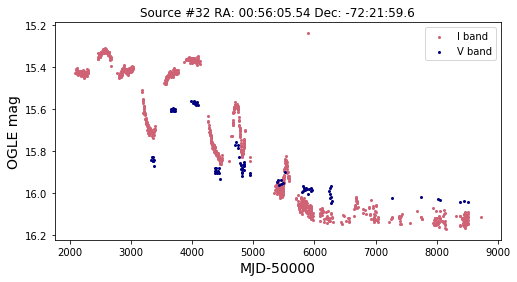

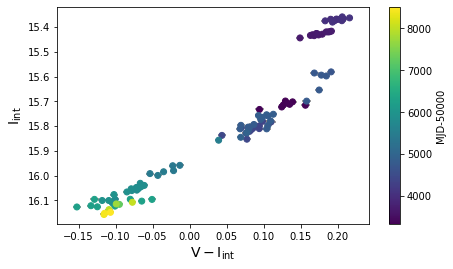

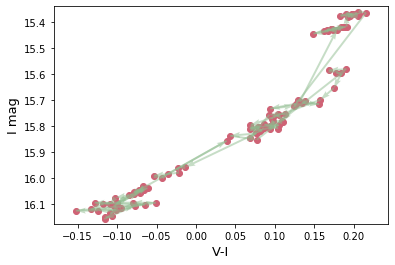

In [52]:
try: iband, vband = o.getIV(32,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(32,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

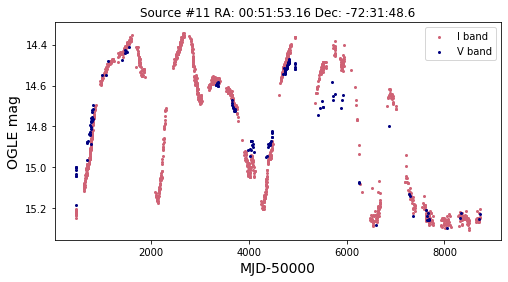

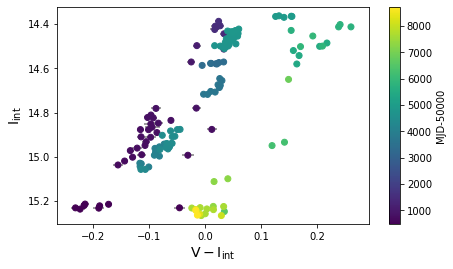

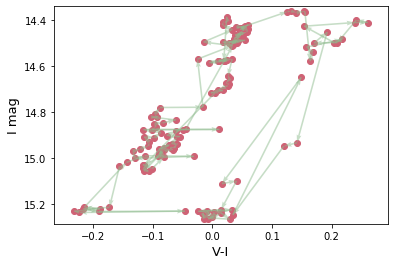

In [55]:
#investigate outliers (higher mean faint res) on other side; worth verifying these numbers
#11,23,62,19,107

#interesting to see flatness in quiescence (no disk?) 
#type 1-adjacent; potentially loopy
try: iband, vband = o.getIV(11,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(11,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

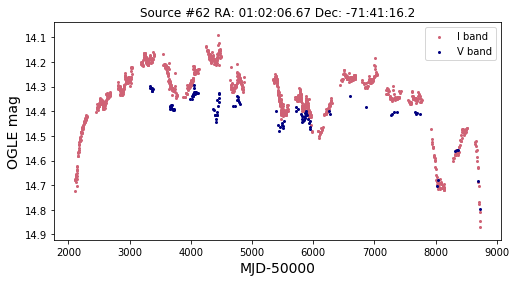

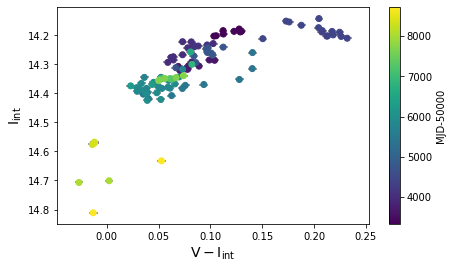

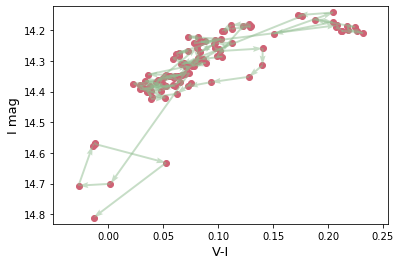

In [57]:
try: iband, vband = o.getIV(62,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(62,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

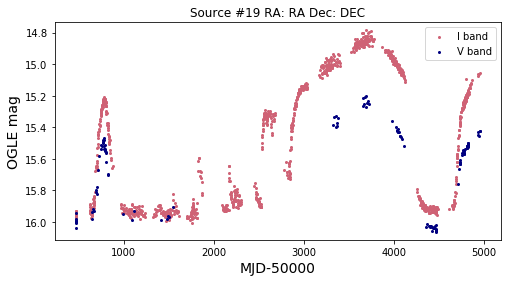

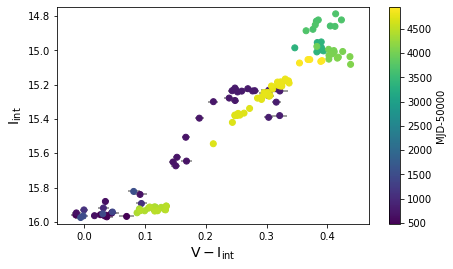

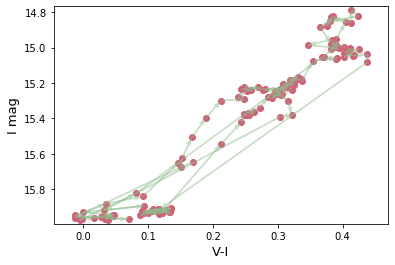

In [58]:
#probably should be added to list of looping, which is again good since type 1 in the beginning
try: iband, vband = o.getIV(19,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(19,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

#### compare slopes in two halves
- possibly expect steeper best fit in brighter region
- does this help differentiate at all

other ideas if not
- see if binning helps (esp. with monotonic fraction)
- try monotonic fraction on original I in I vs. V-I space
- try specifying direction of monotonic trend
- try getting low mean residual (since want symmetry around best fit line), so long as other residual conditions are met


In [19]:
sort_srcs = sorted(srcns)

In [140]:
#add bright and faint half best slopes and intercepts to summtab
fslopes,fints,bslopes,bints = [],[],[],[]
for s in sort_srcs:
    try: fmod,bmod = div_cm(s,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False,retline=True,printall=False)
    except: 
        fmod,bmod = [np.nan,np.nan],[np.nan,np.nan]
        print(f'source {s} not found')
    fslopes.append(fmod[0]);bslopes.append(bmod[0]);fints.append(fmod[1]);bints.append(bmod[1])

empty file for OIII I
source 1 not found
empty file for OIII I
source 51 not found
empty file for OII I
empty file for OIII I


## fit line to brightest points; figure out directionality

In [20]:
#also do at 0.95 to help for search for flattened tops (can just compare to overall slope and intercept)
#replaced by 5 (5 points)
slopes,ints = [],[]
incflag = [] #flag is 0 if no constant time change between five points; 1 if increasing V-I; 2 if decreasing V-I
for s in sort_srcs:
    try: fmod,bmod,flag = div_cm(s,cross=allcross,interp=[],vband=[],frac=5,plot=False,findcorr=False,retline=True,printall=False,retflag=True)
    except: 
        fmod,bmod,flag = [np.nan,np.nan],[np.nan,np.nan],np.nan
        print(f'source {s} not found')
    slopes.append(bmod[0]);ints.append(bmod[1]);incflag.append(flag)

empty file for OIII I
source 1 not found
empty file for OIII I
source 51 not found
empty file for OII I
empty file for OIII I


In [367]:
#being careful to not unintentionally edit summ, so writing the slopes and ints to a different table
hl = pd.DataFrame(columns=['faint slope','faint int','bright slope','bright int'])#half lines
hl['faint slope'] = fslopes
hl['bright slope'] = bslopes
hl['faint int'] = fints
hl['bright int'] = bints

hl['5 bright slope'] = slopes
hl['5 bright int'] = ints
hl.to_csv('colormag_lines.csv')

In [326]:
ints[1]

14.085396923530793

In [21]:
allsumm = pd.read_csv('allsummtab.csv',header=0)

In [369]:
allsumm[:2]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
0      2  20.418930 -72.95907        2.165   2.0        84.00  2.147143  NaN   
1      3  13.639167 -73.68364        2.370   0.8        18.38  0.259701  NaN   

      mean I   stdev I  ...    pf amp  pf phase diff  pf phase max  \
0  14.379506  0.356251  ...  0.016494          0.375       0.84375   
1  14.877813  0.267369  ...  0.007245          0.375       0.03125   

   pf phase min  pf diff mean    pf mean  pf skew   pf kurtosis pf symm sum  \
0       0.46875      0.007994  14.376809 -0.129870    -0.672486    0.003777   
1       0.65625      0.003236  14.874752 -0.146747    -1.208852    0.000911   

  pf mean err  
0    0.001787  
1    0.001850  

[2 rows x 77 columns]

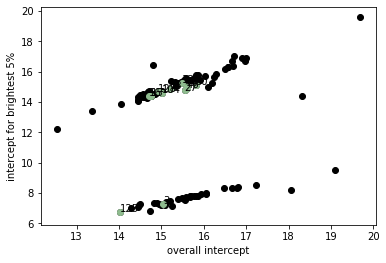

In [346]:
#look at sources based on 0.95 slope and intercept

plt.scatter(allsumm['V V-I int'],allsumm['0.95 int'],color='black')
plt.xlabel('overall intercept')
plt.ylabel('intercept for brightest 5%')
for l in loops:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['V V-I int'],row['0.95 int'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['V V-I int']+.001,row['0.95 int']+.01))


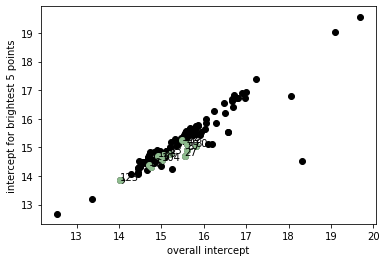

In [373]:
#was this an artifact or does it hold up when 5 points used

plt.scatter(allsumm['V V-I int'],allsumm['5 bright int'],color='black')
plt.xlabel('overall intercept')
plt.ylabel('intercept for brightest 5 points')
for l in loops:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['V V-I int'],row['5 bright int'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['V V-I int']+.001,row['5 bright int']+.01))


flattening would usually involve
- an absolute decrease in slope, so usually a neg value of ~-1 - ~-0.1
- a decrease in intercept (so a positive difference between intercepts)


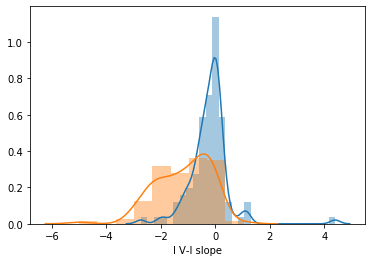

In [380]:
sb.distplot(allsumm['5 bright slope'],label='brightest five slope')
sb.distplot(allsumm['I V-I slope'],label='overall slope')

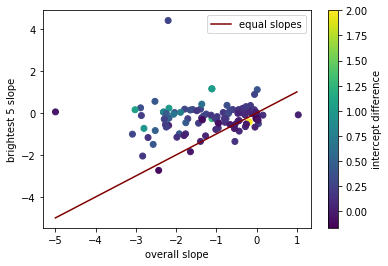

In [22]:
plt.scatter(allsumm['I V-I slope'],allsumm['5 bright slope'],c=allsumm['I V-I int']-allsumm['5 bright int'],vmax=2)
plt.colorbar(label='intercept difference')
plt.xlabel('overall slope')
plt.ylabel('brightest 5 slope')
xs = np.linspace(-5,1)
plt.plot(xs,xs,color='maroon',label='equal slopes')
plt.legend()
# sf('5_overall_intercept')

below: 
- yellow points have decreasing V-I with time
- turquoise points have increasing V-I with time
- the others (purple/navy) are not simply increasing or decreasing

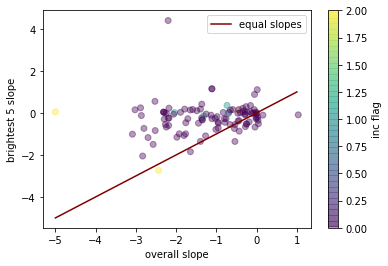

In [27]:
#repeat but color is based on flag

plt.scatter(allsumm['I V-I slope'],allsumm['5 bright slope'],c=incflag[1:],vmax=2,alpha=0.4)
plt.colorbar(label='inc flag')
plt.xlabel('overall slope')
plt.ylabel('brightest 5 slope')
xs = np.linspace(-5,1)
plt.plot(xs,xs,color='maroon',label='equal slopes')
plt.legend()
# sf('brightslope_slope_incflag')

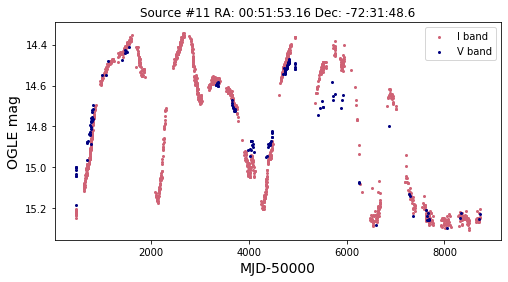

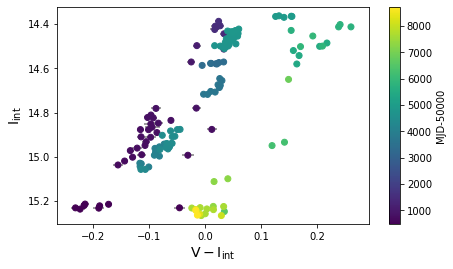

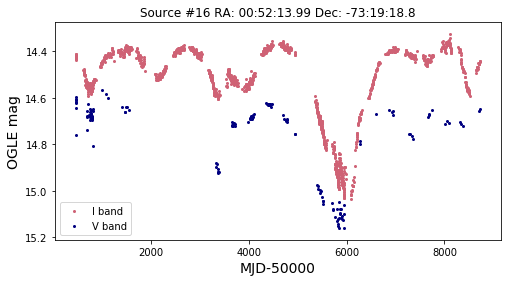

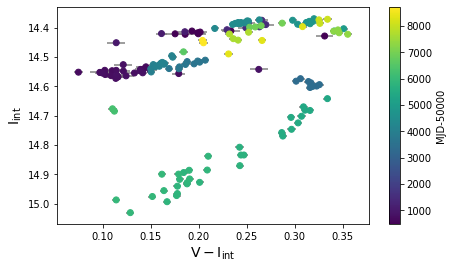

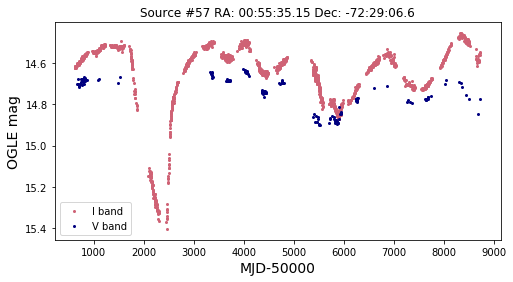

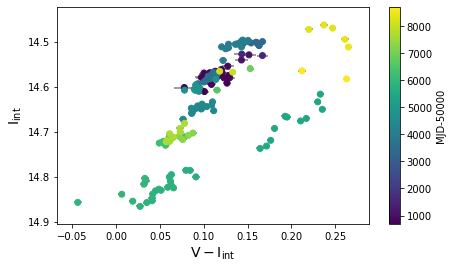

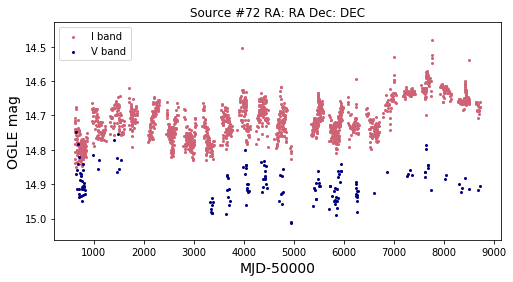

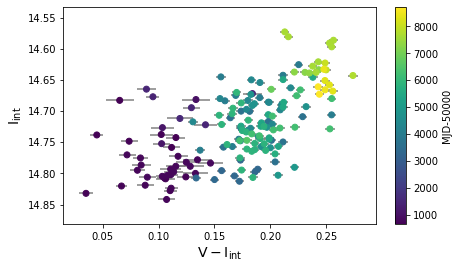

In [30]:
#plot LC and color mag for sources with inc flag of 1 (increasing V-I)
#notice 57 and 16
for s in range(len(sort_srcs)):
    if incflag[s] == 1:
        cm(sort_srcs[s])

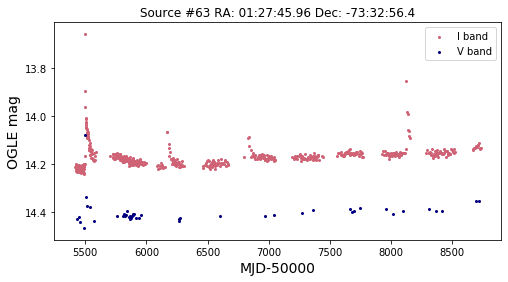

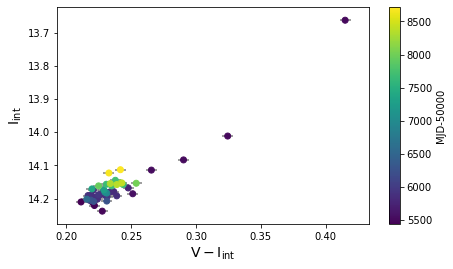

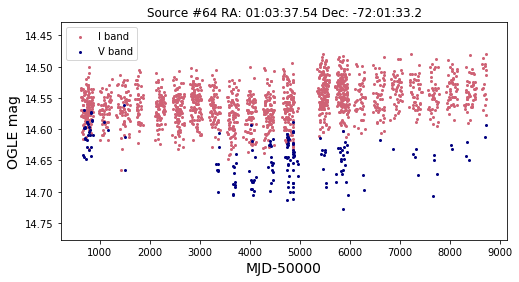

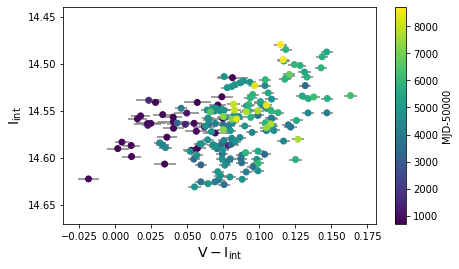

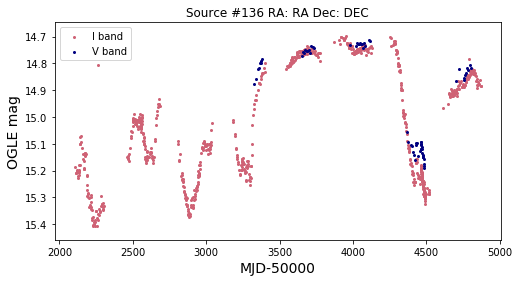

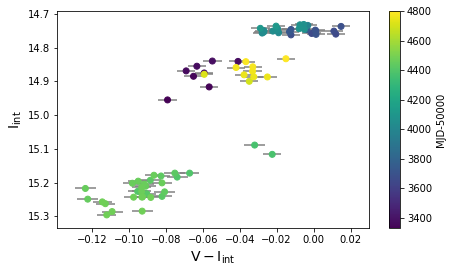

In [31]:
#repeat for decreasing
for s in range(len(sort_srcs)):
    if incflag[s] == 2:
        cm(sort_srcs[s])

## repeat but require bright points from a single epoch
- although more plots from original are below

In [43]:
#get table to get code on
# turn = [16,50,97,106,115,121,136]

b = res_brightness(50,frac=0.5,iband=[],vband=[],interp=[],plot=False,plotres=False,plotrestime=False,retswitch=False,printall=True,retdf=True,
                   div=True,binres=1)

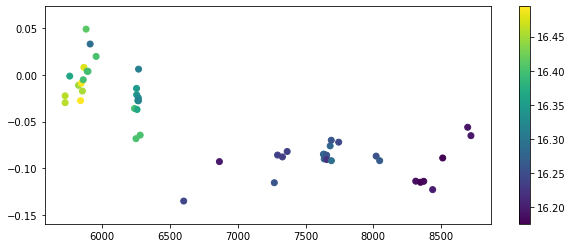

In [45]:
plt.figure(figsize=(10,4))
plt.scatter(b['day'],b['V-I'],c=b['I'])
plt.colorbar()

(16.55, 16.15)

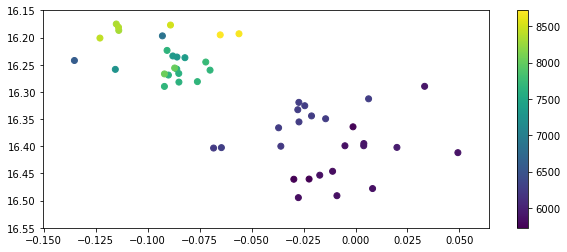

In [48]:
#bluer when brighter at bright values; connected to LC transition
plt.figure(figsize=(10,4))
plt.scatter(b['V-I'],b['I'],c=b['day'])
plt.colorbar()
plt.ylim(16.55,16.15)

In [50]:
#add arrows next; may just need to bin yellow points or allow for slight variation 

Signature: carrow(vband, interp, retvect=False, fs=(6, 4))
Docstring: Add option to first get LCs and interpolated I
File:      ~/Desktop/Yale/OGLE_Project/<ipython-input-8-92403821f000>
Type:      function


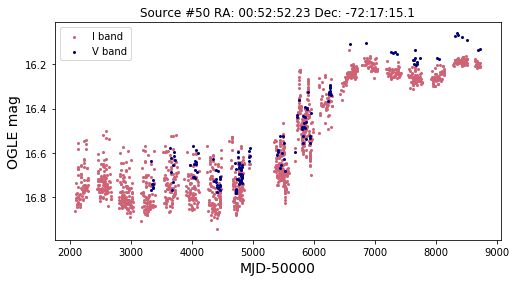

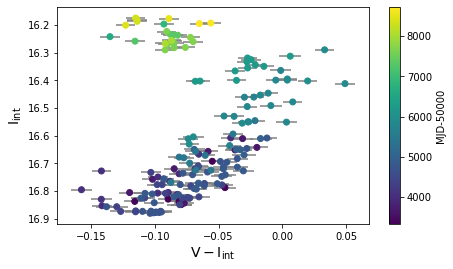

In [49]:
carrow()

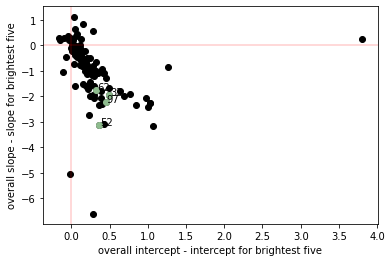

In [401]:
plt.scatter(allsumm['V V-I int']-allsumm['5 bright int'],allsumm['I V-I slope']-allsumm['5 bright slope'],color='black')
plt.xlabel('overall intercept - intercept for brightest five')
plt.ylabel('overall slope - slope for brightest five')
for l in [97,32,62,52]:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['V V-I int']-row['5 bright int'],row['I V-I slope']-row['5 bright slope'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['V V-I int']-row['5 bright int']+.01,row['I V-I slope']-row['5 bright slope']))
plt.axhline(0,color='red',alpha=0.2)
plt.axvline(0,color='red',alpha=0.2)

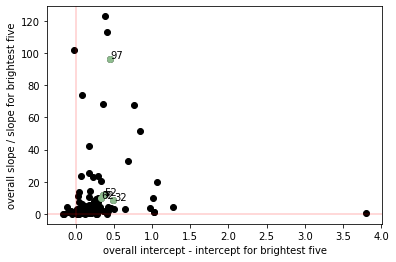

In [435]:
plt.scatter(allsumm['I V-I int']-allsumm['5 bright int'],np.abs(allsumm['I V-I slope']/allsumm['5 bright slope']),color='black')
plt.xlabel('overall intercept - intercept for brightest five')
plt.ylabel('overall slope / slope for brightest five')
for l in [97,32,62,52]:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['I V-I int']-row['5 bright int'],np.abs(row['I V-I slope']/row['5 bright slope']),color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['I V-I int']-row['5 bright int']+.01,np.abs(row['I V-I slope']/row['5 bright slope'])))
plt.axhline(0,color='red',alpha=0.2)
plt.axvline(0,color='red',alpha=0.2)


(-2, 10)

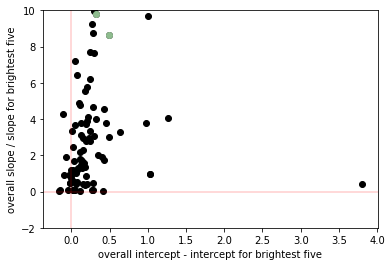

In [436]:
#zoom
plt.scatter(allsumm['I V-I int']-allsumm['5 bright int'],np.abs(allsumm['I V-I slope']/allsumm['5 bright slope']),color='black')
plt.xlabel('overall intercept - intercept for brightest five')
plt.ylabel('overall slope / slope for brightest five')
for l in [97,32,62,52]:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['I V-I int']-row['5 bright int'],np.abs(row['I V-I slope']/row['5 bright slope']),color='darkseagreen')
    #annotate with source number to make follow-up easier
    #plt.annotate(str(l),xy=(row['I V-I int']-row['5 bright int']+.01,np.abs(row['I V-I slope']/row['5 bright slope'])))
plt.axhline(0,color='red',alpha=0.2)
plt.axvline(0,color='red',alpha=0.2)
plt.ylim(-2,10)

#### look at color-mag diagrams of other outliers

In [413]:
#filter table first to values over 40
acopy = allsumm.copy()
acopy['slope ratio'] = allsumm['I V-I slope']/allsumm['5 bright slope']
o40 = acopy[np.abs(acopy['slope ratio'])>40]

In [414]:
o40

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep  \
0        2  20.418930 -72.95907        2.165  2.00        84.00  2.147143   
3        5  12.913330 -72.28433        4.780  1.40         0.00  0.000000   
9       11  12.971667 -72.53000        8.900  1.00        28.51  0.522347   
11      13  16.176208 -72.90122       11.480  0.60        36.30  0.530289   
24      27  13.037084 -72.63416       82.400  0.60       362.30  0.333036   
71      80  12.550833 -73.19889        0.000  1.69         0.00  0.000000   
81      97  13.217584 -72.80828        0.000  1.00         0.00  0.371440   
87     106  13.536150 -72.53543        0.000  1.44         0.00  0.000000   
103    136  16.637384 -73.26193        0.000  0.57         0.00  0.789509   

    name     mean I   stdev I  ...  pf phase diff  pf phase max  pf phase min  \
0    NaN  14.379506  0.356251  ...         0.3750       0.84375       0.46875   
3    NaN  15.549296  0.044747  ...         0.3125       0.21875       0.90625   
9    NaN  14.771583  0.303708  ...         0.5625       0.59375       0.03125   
11   NaN  15.151928  0.265656  ...         0.6250       0.53125       0.90625   
24   NaN  15.115796  0.292898  ...         0.5625       0.96875       0.40625   
71   NaN  15.204009  0.220316  ...         0.5625       0.96875       0.40625   
81   NaN  14.761643  0.293338  ...         0.5000       0.15625       0.65625   
87   NaN  16.991391  0.043595  ...         0.6875       0.46875       0.78125   
103  NaN  15.034754  0.208790  ...         0.5000       0.28125       0.78125   

     pf diff mean    pf mean  pf skew   pf kurtosis  pf symm sum pf mean err  \
0        0.007994  14.376809 -0.129870    -0.672486     0.003777    0.001787   
3        0.008337  15.548018 -0.162822    -0.997413     0.002741    0.001670   
9        0.003811  14.769647 -0.166559    -0.648069     0.000626    0.001615   
11       0.006267  15.150304 -0.671267    -0.088804     0.002282    0.002456   
24       0.129905  15.120591 -0.230719    -1.437425     0.133998    0.025748   
71       0.004737  15.202481  0.284627    -1.265731     0.001519    0.001063   
81       0.008738  14.758147  0.049267    -1.045728     0.002046    0.002301   
87       0.003473  16.990341  0.043461    -0.749256     0.002450    0.001327   
103      0.023802  15.031644 -0.279717    -0.151037     0.014791    0.004599   

    slope ratio  
0    -68.067967  
3    -42.192861  
9   -122.825243  
11  -113.038088  
24   -51.360115  
71   -67.794822  
81    96.480961  
87   -73.781880  
103 -102.076112  

[9 rows x 78 columns]

In [420]:
#confirmed that all the sources flatten out at bright values
# for i in o40['src_n']:
#     #plot LC and cm
#     cm(i)

In [422]:
#intercept outlier
acopy['int diff'] = allsumm['I V-I int']-allsumm['5 bright int']
oint = acopy[np.abs(acopy['int diff'])>0.5]

In [424]:
#high scatter or flatten out
# for i in oint['src_n']:
#     #plot LC and cm
#     cm(i)

In [432]:
#specifically target difference in intercept but ~same slope
#start with ratio of 2 or less
oint4 = oint[oint['slope ratio']<2]

can identify feature at different level (from intercept) even with comparable slope

In [434]:
# for i in oint4['src_n']:
#     #plot LC and cm
#     cm(i)

In [356]:
# for s in sort_srcs:
#     try:
#         row = allsumm[allsumm['src_n']==s]
#         if float(row['0.95 int'])<10:cm(s)
#     except:print('skipping')

#### search for correlations between flattening out and other variables (esp those related to LC)

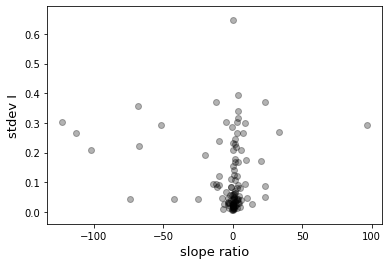

In [447]:
def fplot(xcol='slope ratio',ycol='stdev I',xlog=False,ylog=False):
    plt.scatter(acopy[xcol],acopy[ycol],color='black',alpha=0.3)
    plt.ylabel(ycol,fontsize=13); plt.xlabel(xcol,fontsize=13)
    if xlog: plt.xscale('log')
    if ylog: plt.yscale('log')
fplot()

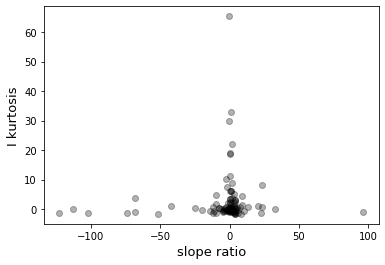

In [449]:
#just probabilistic?
fplot(ycol='I kurtosis')

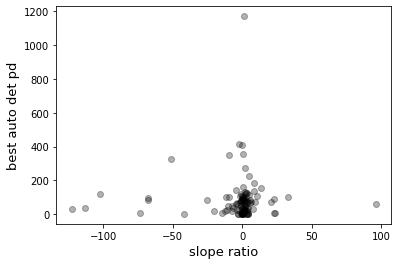

In [443]:
fplot(ycol='best auto det pd')

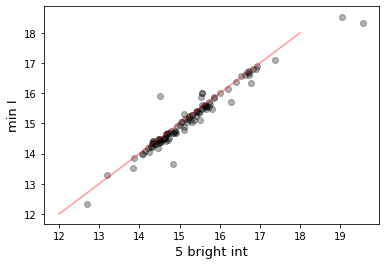

In [464]:
fplot(ycol='min I',xcol='5 bright int')
xs = np.linspace(12,18)
plt.plot(xs,xs,color='red',alpha=0.4)

In [472]:
#show color-mag for outliers
mint = acopy[np.abs(acopy['min - int'])>0.3]

In [471]:
# for m in mint['src_n']:
#     cm(m)

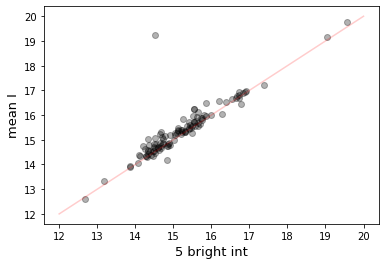

In [506]:
#probably b/c deviations usually small relative to overall span of brightness
fplot(ycol='mean I',xcol='5 bright int')
#ignore top outlier
xs = np.linspace(12,20)
plt.plot(xs,xs,color='red',alpha=0.2)

In [501]:
#more important for outliers than relationship
# plt.scatter(acopy['mean abs bright residual']-acopy['mean abs faint residual'],
#             acopy['I V-I int']-acopy['5 bright int'],color='black')
# plt.ylim(-.5,1.5)

### sources with turn-over (or more)

In [ ]:
turn = [16,50,97,106,115,121,136]
#32,62 a bit diff

#### keep in mind that 16 very interesting: does I lag the V band?

In [545]:
iband,vband = o.getIV(16,cross,stack=True)
interp = o.colormag(iband,vband,retint=True,printcorr=False,plot=False)

In [549]:
corr = scipy.signal.correlate(interp,vband['V mag'],mode='same')
len(corr) - len(interp)

0

(15.2, 14.3)

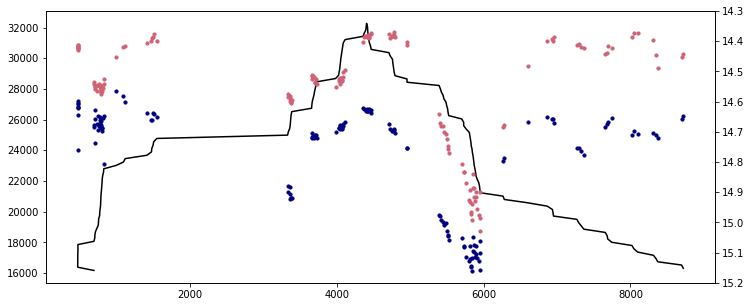

In [558]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(vband['MJD-50000'],corr,color='black')
ax2 = ax.twinx()
ax2.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=10)
ax2.scatter(vband['MJD-50000'],interp,color=pink,s=10)
ax2.set_ylim(15.2,14.3)

(15.2, 14.3)

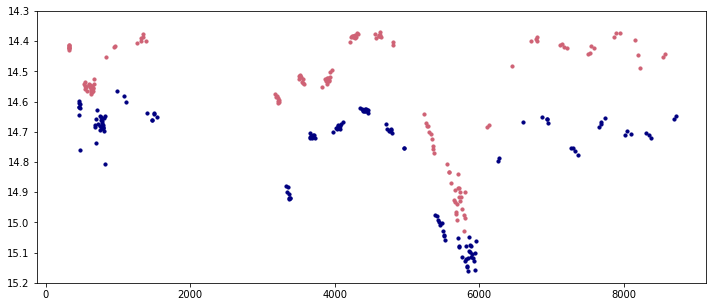

In [577]:
#showing that approximate lag of 150 days
fig = plt.figure(figsize=(12,5))
plt.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=10)
plt.scatter(vband['MJD-50000']-150,interp,color=pink,s=10)
plt.ylim(15.2,14.3)

In [580]:
row = allsumm[allsumm['src_n']==16]
row['mean abs bright residual']-row['mean abs faint residual']

14    0.038104
dtype: float64

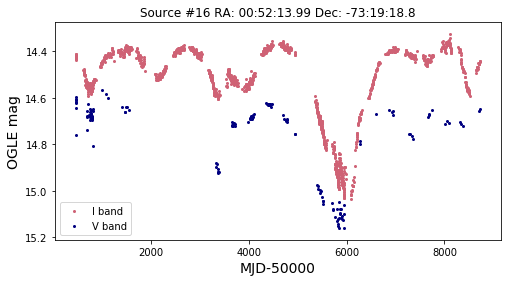

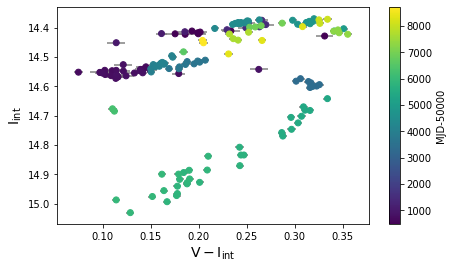

In [540]:
cm(16)

showing there's no fixed I at which a turnover occurs
- but would assume anyway that it would be fixed *for given star*

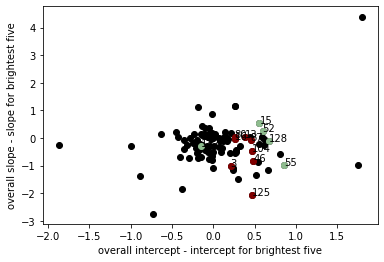

In [587]:
#realized may be useful to use residual difference as fraction of overall average -- see here it helps to separate the loop1 and loop2 sources
plt.scatter((allsumm['mean abs bright residual']-allsumm['mean abs faint residual'])/allsumm['mean abs I vs. V-I residual'],allsumm['5 bright slope'],color='black')
plt.xlabel('overall intercept - intercept for brightest five')
plt.ylabel('overall slope - slope for brightest five')
#for l in [97,32,62,52,16,50,106,115,121,136]:
for l in loop1:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['5 bright slope'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['5 bright slope']))
    
for l in loop2:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['5 bright slope'],color='maroon')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['5 bright slope']))

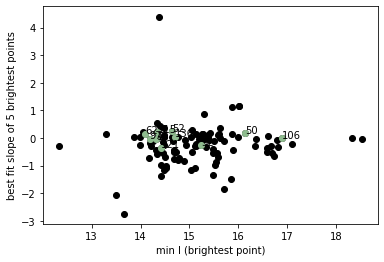

In [539]:
plt.scatter(allsumm['min I'],allsumm['5 bright slope'],color='black')
plt.xlabel('min I (brightest point)')
plt.ylabel('best fit slope of 5 brightest points')
for l in [97,32,62,52,16,50,106,115,121,136]:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['min I'],row['5 bright slope'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['min I'],row['5 bright slope']))
# plt.axhline(0,color='red',alpha=0.2)
# plt.axvline(0,color='red',alpha=0.2)


already have bright - faint slope but nice to decompose

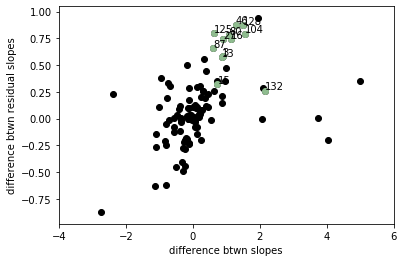

In [334]:
plt.scatter(allsumm['bright slope']-allsumm['faint slope'],allsumm['residual slope diff'],color='black')
plt.xlim(-4,6)
plt.xlabel('difference btwn slopes')
plt.ylabel('difference btwn residual slopes')
for l in loops:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['bright slope']-row['faint slope'],row['residual slope diff'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright slope']-row['faint slope']+.001,row['residual slope diff']+.01))

- idea of most loops being somewhere in parameter space
- question: do the neighbors of 132 look like it?

(-0.8, 0.5)

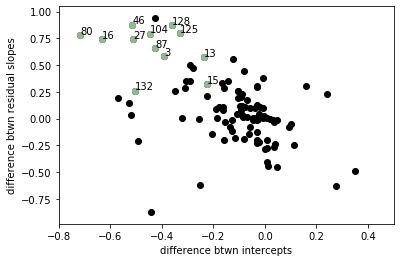

In [335]:
plt.scatter(allsumm['bright int']-allsumm['faint int'],allsumm['residual slope diff'],color='black')
plt.xlabel('difference btwn intercepts')
plt.ylabel('difference btwn residual slopes')
for l in loops:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['bright int']-row['faint int'],row['residual slope diff'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright int']-row['faint int']+.001,row['residual slope diff']+.01))
plt.xlim(-.8,0.5)

(-2, 6)

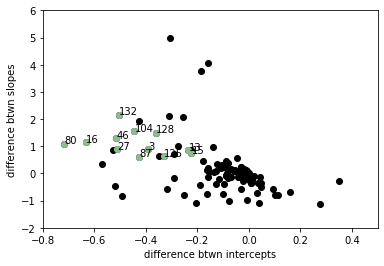

In [336]:
plt.scatter(allsumm['bright int']-allsumm['faint int'],allsumm['bright slope']-allsumm['faint slope'],color='black')
plt.xlabel('difference btwn intercepts')
plt.ylabel('difference btwn slopes')
for l in loops:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['bright int']-row['faint int'],row['bright slope']-row['faint slope'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright int']-row['faint int']+.001,row['bright slope']-row['faint slope']+.01))
plt.xlim(-.8,0.5)
plt.ylim(-2,6)

(-0.8, 0.5)

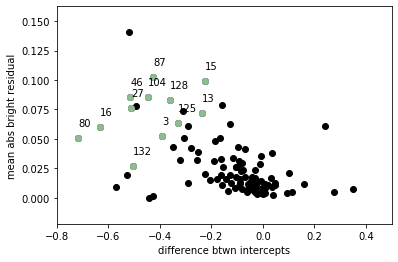

In [337]:
plt.scatter(allsumm['bright int']-allsumm['faint int'],allsumm['mean abs bright residual'],color='black')

plt.xlabel('difference btwn intercepts')
plt.ylabel('mean abs bright residual')
for l in loops:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter(row['bright int']-row['faint int'],row['mean abs bright residual'],color='darkseagreen')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright int']-row['faint int']+.001,row['mean abs bright residual']+.01))
plt.xlim(-.8,0.5)


In [68]:
b,f,bslope,mfrac,ns,sd = res_brightness(15,plot=False,printall=False,frac=0.5,retslope=True,div=False,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)

In [74]:
#calculate four dimensions for all sources (here to get slope differences and test out which column used in monofrac)
#comment out once slopes added to table
useboth = False
fsums,bsums,slopes,fracs,nswitch,sdiff = [],[],[],[],[],[]
for s in sort_srcs:
    try: #skips 1,51,78
        b,f,bslope,mfrac,ns,sd = res_brightness(s,plot=False,printall=False,frac=0.5,retslope=True,div=False,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)
        fsums.append(f);bsums.append(b);slopes.append(bslope);fracs.append(mfrac); sdiff.append(sd);nswitch.append(ns)
    except:
        print(f'source {s} not found')
        fsums.append(np.nan);bsums.append(np.nan);slopes.append(np.nan);fracs.append(np.nan); sdiff.append(np.nan); nswitch.append(np.nan)

empty file for OIII I
source 1 not found
empty file for OIII I
source 51 not found
empty file for OII I
source 78 not found
empty file for OIII I


In [75]:
# summ['bright - faint slope'] = sdiff

# #write out summtab
# summ.to_csv('summtab.csv',index=False)

new dimension could be useful for something like PCA but does not seem to be any more useful than the residual slope difference

In [76]:
summ['number switch'] = nswitch

In [77]:
#do number switch when useboth
scopy = summ.copy() #for testing
# if useboth:
scopy['number switch'] = nswitch 
# copy summ to add temp columns
# if not useboth:
scopy['mono frac 2'] = fracs 
scopy['mean abs bright residual'] = bsums
scopy['mean abs faint residual'] = fsums
scopy['bright res monotonic frac'] = fracs
scopy['number switch'] = nswitch
scopy['residual slope diff'] = slopes
scopy['bright - faint slope'] = sdiff

using absolute number rather than fraction helps separate all but 86,132
- since 132 just has very few points in loop
- 132 has other features at low values, hence the slope and res difference not being a huge help
    - although slope is shallower at faint values, so bright - faint slope column helpful
- next test to help 132: mean rather than abs mean residual, since loop residuals should have symmetry
    

mean res without absolute value not really helpful 

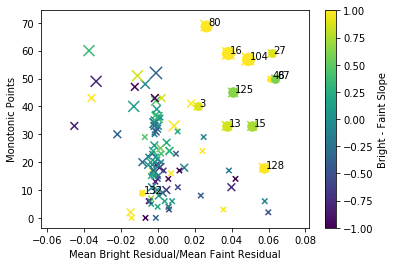

In [83]:
#place for testing
plt.scatter(scopy['mean abs bright residual']-scopy['mean abs faint residual'],scopy['mono frac 2'],c=scopy['bright - faint slope'],marker='x',label='all sources',vmin=-1,vmax=1,s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = scopy[scopy['src_n']==l]
    plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['mono frac 2'],c=row['bright - faint slope'],marker='o',vmin=-1,vmax=1,s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['mono frac 2']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright - Faint Slope')
plt.xlabel('Mean Bright Residual/Mean Faint Residual')
plt.ylabel('Monotonic Points')
# plt.xscale('log')
# sf('mono_nodiv')

In [76]:
#make table for by-eye loop sources
ltab = scopy[scopy['src_n']==loops[0]]
for l in loops[1:]:
    row = scopy[scopy['src_n']==l]
    ltab = pd.concat([ltab,row])

Text(0, 0.5, 'Monotonic Fraction')

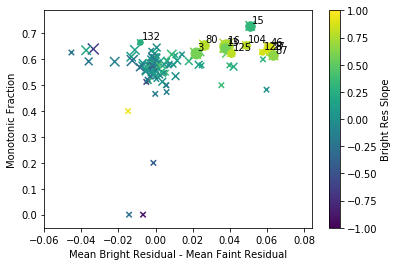

In [79]:
#repeat with fraction
plt.scatter(summ['mean abs bright residual']-summ['mean abs faint residual'],summ['bright res monotonic frac'],c=summ['residual slope diff'],marker='x',label='all sources',vmin=-1,vmax=1,s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['bright res monotonic frac'],c=row['residual slope diff'],marker='o',vmin=-1,vmax=1,s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['bright res monotonic frac']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Monotonic Fraction')
# plt.xscale('log')

higher monotonic minimum helps 132

### try combine dimensions into metric
- want high monotonic fraction, usually high mean bright res - mean faint res, high bright res slope, high nswitch

In [372]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note', 'I skew', 'I kurtosis',
       'V skew', 'V kurtosis', 'best auto det pd', 'Part', 'I IQR',
       'aperiodic quiescence', 'abs mean I vs. V-I residual',
       'mean abs faint residual', 'mean abs bright residual',
       'residual slope diff', 'bright res monotonic frac',
       'bright - faint slope', 'mono frac 2', 'mean bright', 'mean faint',
       'number switch', 'metric'],
      dtype='object')

In [87]:
#for each variable, normalize to maximum
nmfrac = summ['bright res monotonic frac']/np.nanmax(summ['bright res monotonic frac'])
nresdiff = (summ['mean abs bright residual']-summ['mean abs faint residual'])/np.nanmax(summ['mean abs bright residual']-summ['mean abs faint residual'])
nslope = summ['residual slope diff']/np.nanmax(summ['residual slope diff'])

In [88]:
summ['metric'] = nmfrac + nresdiff + nslope #+ nswitch

plot below evenly weighs each relevant metric
- 132 not with group, but plot shhows potential relevance of dimension not incldued: bright - faint slope so will test use below
- 132 has a higher monotonic fraction than its neighbors

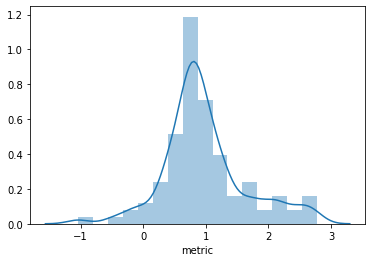

In [89]:
sb.distplot(summ['metric'])

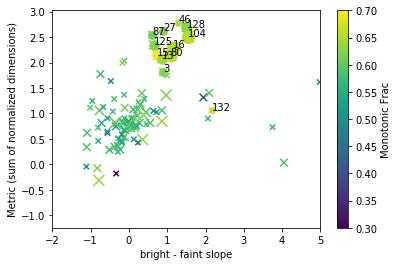

In [91]:
plt.scatter(summ['bright - faint slope'],summ['metric'],c=summ['bright res monotonic frac'],vmin=0.3,vmax=0.7,marker='x',label='all sources',s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['bright - faint slope'],row['metric'],c=row['bright res monotonic frac'],vmin=0.3,vmax=0.7,marker='o',s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright - faint slope']+.001,row['metric']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Monotonic Frac')
# plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Metric (sum of normalized dimensions)')
#cut out outler around 18 with low mono frac
plt.xlim(-2,5)
plt.xlabel('bright - faint slope')
# sf('metric_slope')

In [500]:
phase = pd.read_csv('phasetab.csv')

In [501]:
phase.columns

Index(['src_n', 'period', 'amp', 'phase diff', 'phase max', 'phase min',
       'shape', 'diff mean', 'mean', 'skew', 'kurtosis', 'symm sum',
       'mean err', 'aperiodic quiescence'],
      dtype='object')

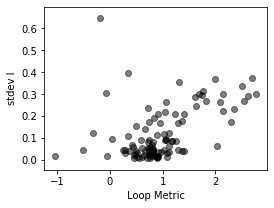

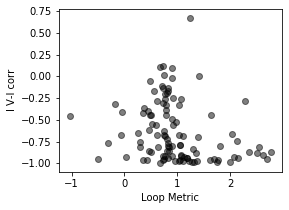

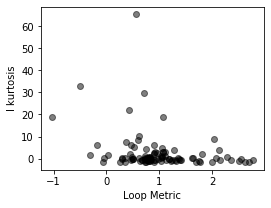

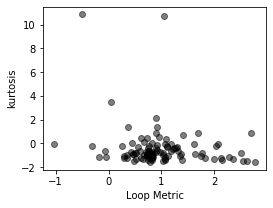

In [516]:
#beginnings of searching for connections between loop metric and other
#will get better once columns added that describe type 1 sources
def loopcorr(col='stdev I',table=summ):
    plt.figure(figsize=(4,3))
    plt.scatter(summ['metric'],table[col],color='black',alpha=0.5)
    plt.xlabel('Loop Metric')
    plt.ylabel(col)
loopcorr()

loopcorr(col='I V-I corr')

loopcorr(col='I kurtosis')

loopcorr(col='kurtosis',table=phase)

# loopcorr(col='period',table=phase)


In [411]:
nslope2 = summ['bright - faint slope']/np.max(summ['bright - faint slope'])
summ['metric2'] = nmfrac + nresdiff + nslope + nslope2 #+ nswitch

Text(0, 0.5, 'Metric')

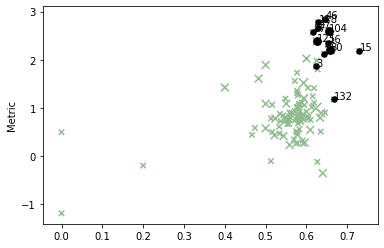

In [416]:
plt.scatter(summ['bright res monotonic frac'],summ['metric2'],color='darkseagreen',marker='x',label='all sources',s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['bright res monotonic frac'],row['metric2'],color='black',marker='o',s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright res monotonic frac']+.001,row['metric2']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
# plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Metric')


Text(0.5, 0, 'Metric 1')

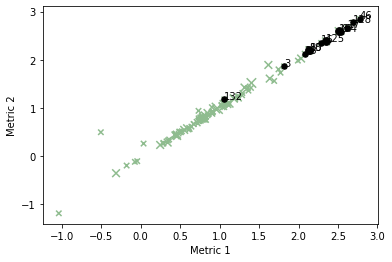

In [418]:
plt.scatter(summ['metric'],summ['metric2'],color='darkseagreen',marker='x',label='all sources',s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['metric'],row['metric2'],color='black',marker='o',s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['metric']+.001,row['metric2']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
# plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Metric 2')
plt.xlabel('Metric 1')

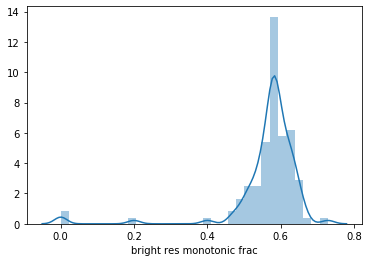

In [518]:
sb.distplot(summ['bright res monotonic frac'])

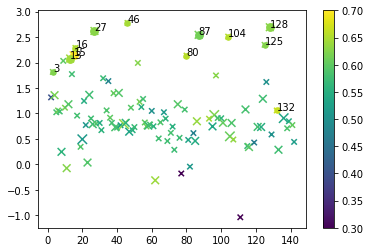

In [521]:
#weird plot but essentially trying to do histogram of metric while allowing for annotation
plt.scatter(summ['src_n'],summ['metric'],c=summ['bright res monotonic frac'],vmin=0.3,vmax=0.7,marker='x',label='all sources',s=30*(summ['number switch']+1))
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['src_n'],row['metric'],c=row['bright res monotonic frac'],vmin=0.3,vmax=0.7,marker='o',s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['src_n']+.001,row['metric']+.01))
plt.colorbar()

# Look into Correlations btwn Individual Loop Metrics and LCs

actually would further divide into two possible populations
- 15,128,132(type 1 and loops are closed and in order)
    - check 13
    - may want to try to add 52, 55 (or even part of them)
- 3,16,13(?),46,125,80,87,104

#### I think the name of the counter-clockwise game is a type 1-like peak
- see 104 below

(-0.4, 0.4)

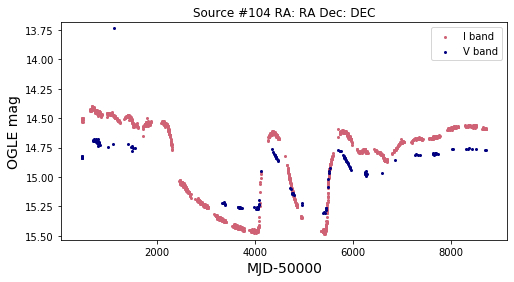

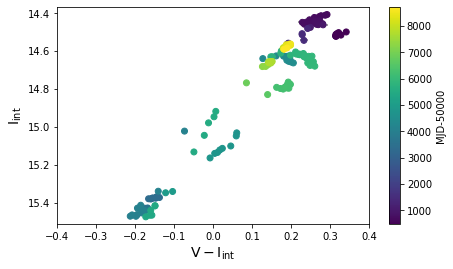

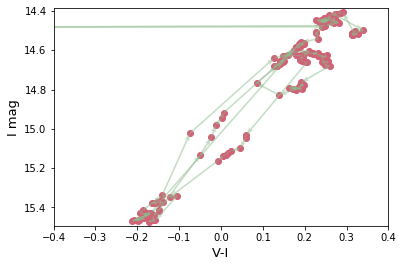

In [46]:
# show LCs of all definite loop sources
# for l in loops:
try: iband, vband = o.getIV(l,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(l,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
plt.xlim(-0.4,0.4)
carrow(vband,interp,retvect=False,fs=(6,4))
plt.xlim(-0.4,0.4)

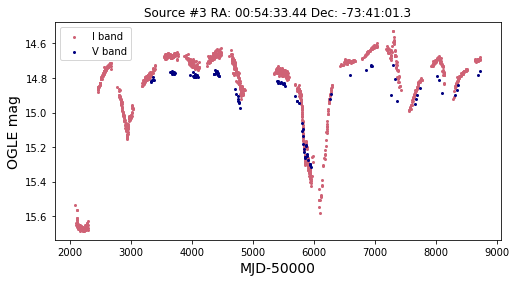

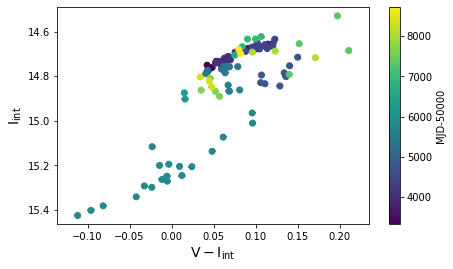

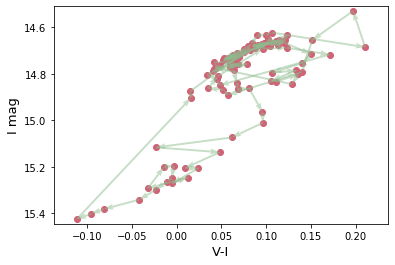

In [47]:
try: iband, vband = o.getIV(3,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(3,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

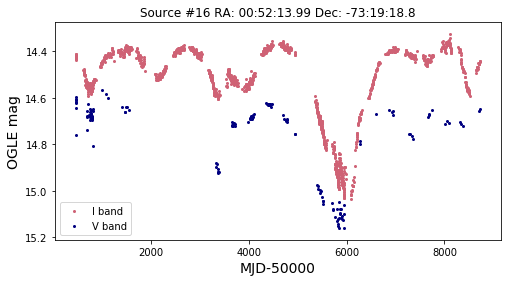

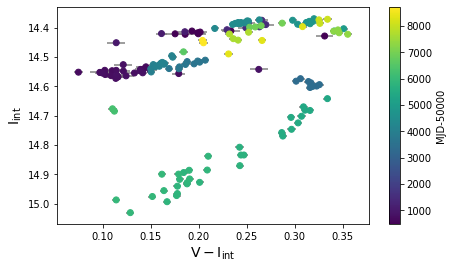

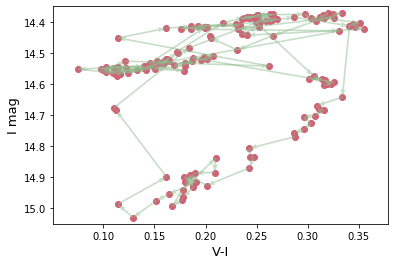

In [50]:
try: iband, vband = o.getIV(16,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(16,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))
#repeat but zoom in to better see arrows
# carrow(vband,interp,retvect=False,fs=(6,4))
# plt.ylim(14.6,14.3) #may want to have both color and arrows

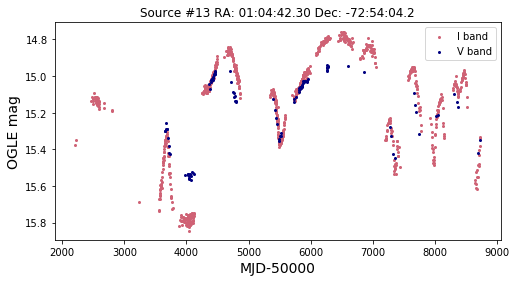

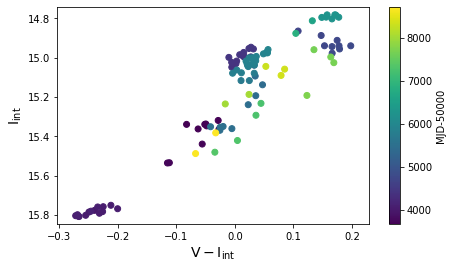

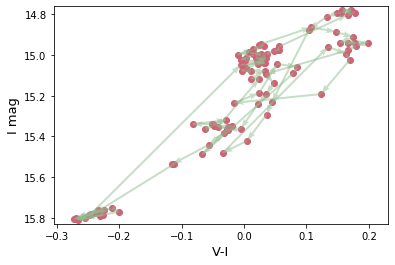

In [51]:
try: iband, vband = o.getIV(13,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(13,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

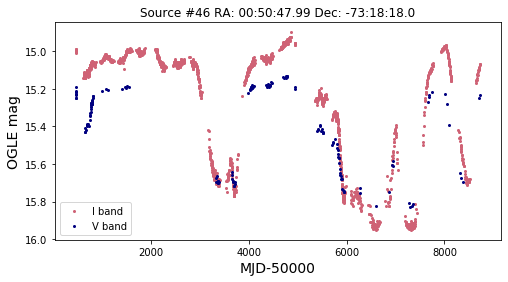

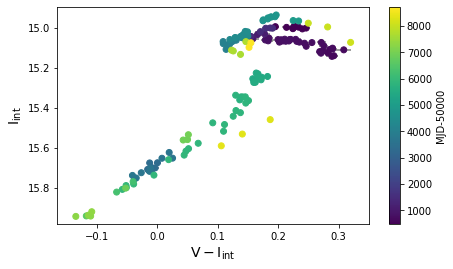

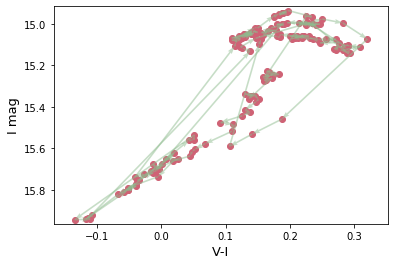

In [52]:
try: iband, vband = o.getIV(46,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(46,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

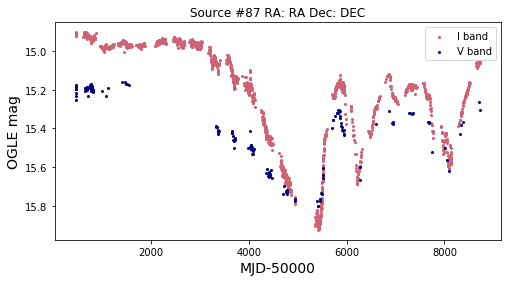

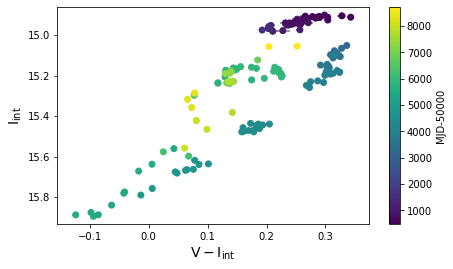

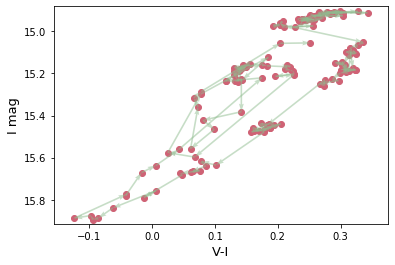

In [55]:
try: iband, vband = o.getIV(87,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(87,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

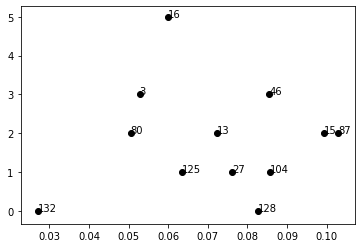

In [89]:
#do any existing dimensions differentiate
xcol = 'mean abs bright residual'
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row[xcol],row['number switch'],color='black')
    #annotate
    plt.annotate(str(l),xy=(row[xcol],row['number switch']))

In [93]:
#try to calculate nswitch after adjusting binning
#e.g. don't bin 132 but bin if more coverage
switches = []
for l in loops:
    b,f,bslope,mfrac,ns,sd = res_brightness(l,plot=False,printall=False,frac=0.5,retslope=True,div=True,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres='auto')
    switches.append(ns)

In [93]:
#separate lists of sources for possible populations
loop1 = [15,128,132,52,55]
loop2 = [3,16,13,46,125,80,87,104]

In [97]:
sdict = dict(zip(loops, switches)) 
sdict #not too helpful right now

{3: 0,
 15: 1,
 16: 1,
 13: 1,
 27: 1,
 46: 1,
 125: 0,
 80: 0,
 87: 0,
 132: 0,
 128: 0,
 104: 1}

### tried comparing data ranges
- in meeting; try discussing what best quantifies bimodality b/c this could generally be helpful w/ loops but also help with subgroups


In [286]:
b1 = res_brightness(15,plot=False,retdf=True,printall=False,frac=0.5,retslope=True,div=True,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)

In [287]:
b2 = res_brightness(3,plot=False,retdf=True,printall=False,frac=0.5,retslope=True,div=True,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)

In [293]:
maxres = np.max(b1['residual'])
maxres

0.2300476287402713

In [298]:
len(b1['residual'][np.abs(b1['residual'])>maxres/2])/len(b2)

0.22580645161290322

In [299]:
maxres2 = np.max(b2['residual'])
# print(maxres2)
len(b2['residual'][np.abs(b2['residual'])>maxres2/2])/len(b2)

0.053763440860215055

In [258]:
st.iqr(b1['residual'],rng=(10,30))/st.iqr(b1['residual'],rng=(80,90))

1.0422872892839976

In [259]:
st.iqr(b2['residual'],rng=(10,30))/st.iqr(b2['residual'],rng=(80,90))

0.3944454614306064

In [260]:
st.iqr(b2['residual'],rng=(10,30))

0.01486519277383351

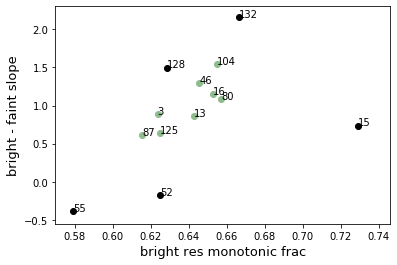

In [94]:
def compare(xcol = 'bright res monotonic frac',ycol = 'bright - faint slope',table=summ):
    for l in loop1:
        row = table[table['src_n']==l]
        plt.scatter(row[xcol],row[ycol],color='black')
        #annotate
        plt.annotate(str(l),xy=(row[xcol],row[ycol]))

    for l in loop2:
        row = table[table['src_n']==l]
        plt.scatter(row[xcol],row[ycol],color='darkseagreen')
        #annotate
        plt.annotate(str(l),xy=(row[xcol],row[ycol]))
    plt.ylabel(ycol,fontsize=13);plt.xlabel(xcol,fontsize=13)
compare()

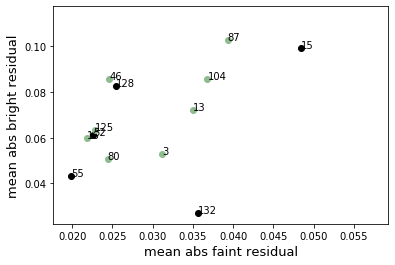

In [115]:
compare(ycol='mean abs bright residual',xcol='mean abs faint residual')

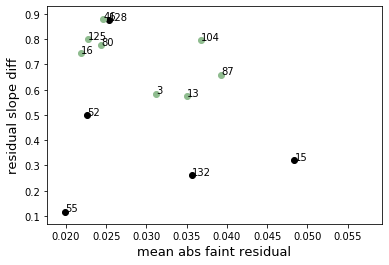

In [116]:
compare(ycol='residual slope diff',xcol='mean abs faint residual')

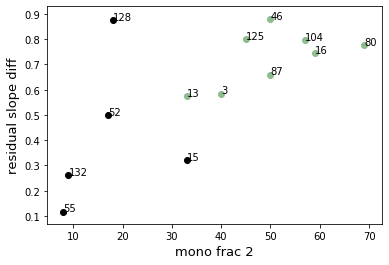

In [120]:
compare(ycol='residual slope diff',xcol='mono frac 2',table=scopy)

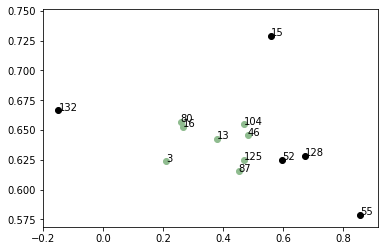

In [592]:
for l in loop1:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['bright res monotonic frac'],color='black')
    #annotate
    plt.annotate(str(l),xy=((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['bright res monotonic frac']))

for l in loop2:
    row = allsumm[allsumm['src_n']==l]
    plt.scatter((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['bright res monotonic frac'],color='darkseagreen')
    #annotate
    plt.annotate(str(l),xy=((row['mean abs bright residual']-row['mean abs faint residual'])/row['mean abs I vs. V-I residual'],row['bright res monotonic frac']))

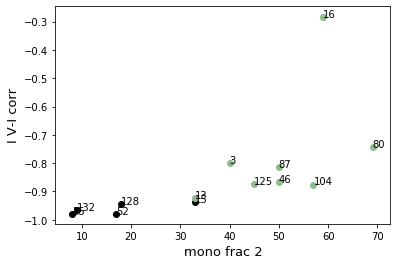

In [130]:
#best one
compare(ycol='I V-I corr',xcol='mono frac 2',table=scopy)
plt.savefig('Figs/corr_frac2_looptypes.png',dpi=150,bbox_inches='tight')

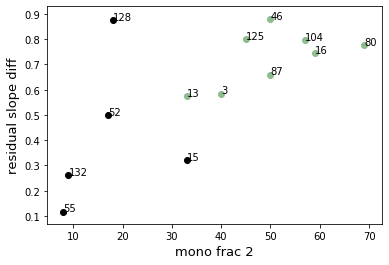

In [128]:
compare(ycol='residual slope diff',xcol='mono frac 2',table=scopy)

#### briefly try pca with columns thus far
- then continue refining mono, by looking for turnover in monotonic (sort of give points for going from string of strictly increasing to string of strictly decreasing)
- all loops lie along pca 1 vs. pca 2 main trend, but in future can check out significance of outliers

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
def fullpca(tab,features,n=2,retdf=True,addpart=True):
    '''Standardize features and perform pca with n components'''
    #only keep rows where feature is not a nan
    df = tab[np.isnan(tab[features[0]])==False]
    #loop through remaining features
    for f in features[1:]:
        df = df[np.isnan(df[f])==False]
    print(len(df))
    x = df.loc[:, features]
    # Separating out the target
    y = df.loc[:,['src_n']]
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #perform PCA with n components
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(x)
    columns = ['']*n
    for c in range(1,n+1):
        columns[c-1] = f'pc {c}'
    pdf = pd.DataFrame(data = principalComponents, columns = columns)
    #add part to pdf
    if addpart:
        part = np.array(df['Part'])
        pdf['Part'] = part
        pdf['src_n'] = df['src_n']
    print(f'explained variance by component:{pca.explained_variance_ratio_}')
    if retdf: return df,pdf
    else: return pdf

In [22]:
features = ['bright - faint slope', 'bright res monotonic frac','mean abs faint residual', 'mean abs bright residual',
           'residual slope diff']
df,pdf = fullpca(summ,features,n=5)

106
explained variance by component:[0.41309443 0.25574104 0.20560272 0.08995383 0.03560796]


In [28]:
enumerate(pdf)

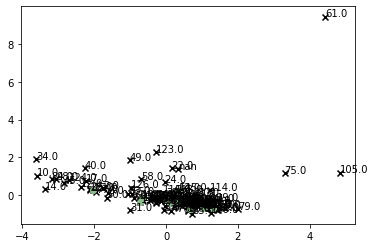

In [30]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],color='black',marker='x')
for p in range(len(pdf)):
    plt.annotate(str(pdf.loc[p]['src_n']),xy=(pdf.loc[p]['pc 1'],pdf.loc[p]['pc 2']))
for l in loops:
    row = pdf[pdf['src_n']==l]
    plt.scatter(row['pc 1'],row['pc 2'],color='darkseagreen',marker='o')


In [35]:
#plot color-mags and LCs of outliers
# try: iband, vband = o.getIV(61,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(61,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

# try: iband, vband = o.getIV(105,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(105,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

# try: iband, vband = o.getIV(75,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(75,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

# try: iband, vband = o.getIV(123,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(123,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

# try: iband, vband = o.getIV(49,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(49,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

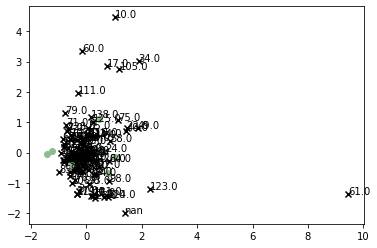

In [38]:
plt.scatter(pdf['pc 2'],pdf['pc 3'],color='black',marker='x')
for l in loops:
    row = pdf[pdf['src_n']==l]
    plt.scatter(row['pc 3'],row['pc 5'],color='darkseagreen',marker='o')
for p in range(len(pdf)):
    plt.annotate(str(pdf.loc[p]['src_n']),xy=(pdf.loc[p]['pc 2'],pdf.loc[p]['pc 3']))

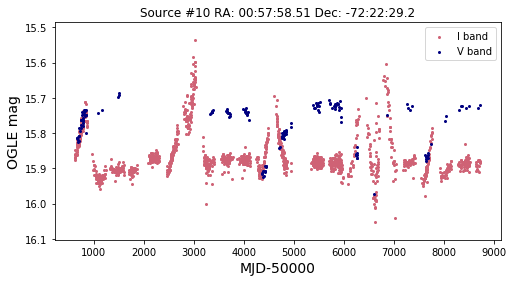

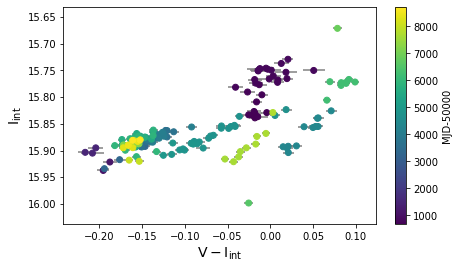

In [39]:
#very strange behavior, since V brightest when I not; but then normal trend during peaks
try: iband, vband = o.getIV(10,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(10,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

In [126]:
#lowest false positives: original
farr = np.array(fracs)
farr_o = np.array(summ['bright res monotonic frac'])
print(f'num of false positives using just mono fraction: {len(farr[farr>0.42]) - len(loops)}')

num of false positives using just mono fraction: 14


faint sum of abs residuals: 0.04838612282268458
bright sum of abs residuals: 0.09942609550728602
faint sum of abs residuals: 0.02186586084307213
bright sum of abs residuals: 0.059969469305394534


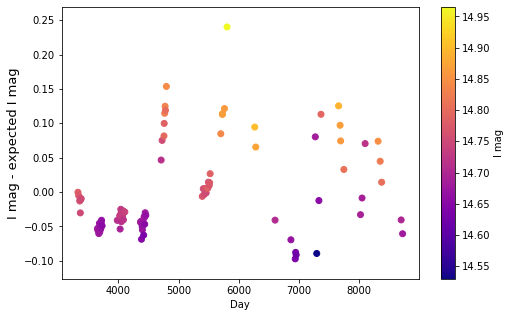

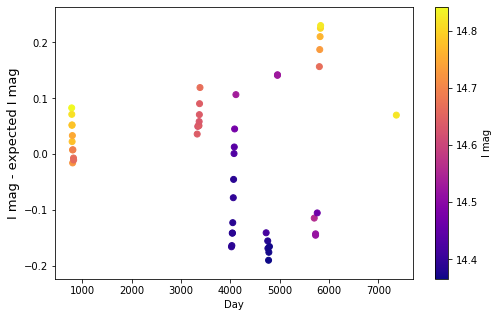

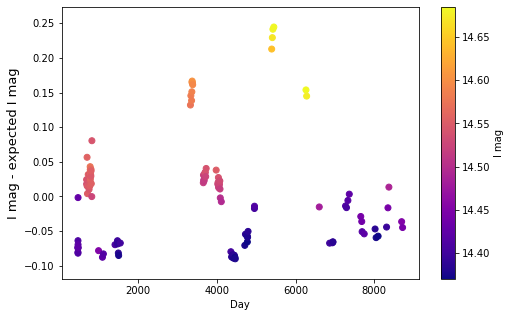

In [15]:
sums = res_brightness(3,plot=False,plotrestime=True,retdf=True)
sums = res_brightness(15,plot=False,plotrestime=True)
sums = res_brightness(16,plot=False,plotrestime=True)

In [ ]:
# leaving old code mono counter here for now
#     num_mon = 0 #counter for monotonic
#     for p in peaks:
#         #loop thru points before
#         sub = 2 #value to subtract to start
#         mono = True
#         while mono:
#             #reset bool mono based on whether or not it's still monotonic
#             mono = o.monotonic(bdf['residual'][p-sub:p])
#             sub+=1
#         #add to num_mon based on what sub left off on; it automatically gets to 3
#         num_mon += sub-3

#         #repeat for points after peak
#         sub = 2
#         mono = True
#         while mono and p+sub<len(bdf['residual']):
#             mono = o.monotonic(bdf['residual'][p:p+sub])
#             sub+=1
#         #add to num_mon based on what sub left off on; it automatically gets to 3
#         num_mon += sub-3
#     if divide: return num_mon/len(bdf)
#     return num_mon

doesn't need to be repeated (so commented out), but added mean residual to summ tab
- once this method done, decide what other residual/loop info to add

In [71]:
sort_srcs = sorted(srcns)

In [72]:
#add color-mag residuals to summ tab
# summ['abs mean I vs. V-I residual'] = np.zeros(len(summ))

In [73]:
# means = []
# for s in sort_srcs: 
#     try: 
#         try: iband, vband = o.getIV(s,cross,stack=True,plot=False,mlist=mlist1)
#         except: iband, vband = o.getIV(s,cross2,stack=True,plot=False,mlist=mlist2)
#         interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
#         plt.close()
#         #linear best fit to color-mag
#         mod = np.polyfit(vband['V mag']-interp,interp,1)
#         #predicted I mag based on linear best fit
#         expecti = (vband['V mag']-interp)*mod[0] + mod[1]
#         #calculate residuals
#         residuals = interp - expecti
#         #mean residual abs value
#         mean_res = np.mean(np.abs(residuals))
#         #add to list before adding to table
#         means.append(mean_res)
#     except: 
#         #add nan to list
#         means.append(np.nan)
#         print(f'source {s} not found')   

empty file for OIII I
source 1 not found
empty file for OIII I
source 51 not found
empty file for OII I
empty file for OIII I


In [74]:
# summ['mean abs I vs. V-I residual'] = means

In [26]:
#new suggestion: try binning points 1/10th to 1/20th of timescale of loops e.g. 50-100 for 1000 day loop
def bincolor(srcn,iband=[],vband=[],interp=[],binsize=150,plot=False,plotbinned=True):
    '''binsize: width of bins in days'''
    #check if iband,vband,interp already passed in
    if len(iband)<1:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=plot,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=plot,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
        if not plot: plt.close()
    #turn interp and v-i into arrays for ease with splitting
    interp = np.array(interp)
    vi = np.array(vband['V mag'])-interp
    vband['I'],vband['V-I'] = interp,vi
    #get total time of vband data
#     totlen = vband['MJD-50000'].iloc[-1] - vband['MJD-50000'].iloc[0] 
    start,end = vband['MJD-50000'][:1], vband['MJD-50000'][-1:]
    bins = np.arange(start,end,binsize)
    avgi,avgvi = [],[]
    #loop through bins and get average I and V-I
    for i in range(1,len(bins)):
        tempv = vband[vband['MJD-50000']>bins[i-1]]
        tempv = tempv[tempv['MJD-50000']<=bins[i]]
        #now get avgi and avgvi from temp table
        avgi.append(np.mean(tempv['I']))
        avgvi.append(np.mean(tempv['V-I']))
    if plotbinned: #plot binned color-mag
        plt.scatter(avgvi,avgi,color='black')
        plt.ylabel('binned I mag');plt.xlabel('binned V-I')
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.02,mini-.02)

In [68]:
#calculate four dimensions for all sources and add to summ and allsumm tables
# fsums,bsums,slopes,fracs = [],[],[],[]
# for s in sort_srcs:
#     try: #skips 1,51,78
#         b,f,bslope,mfrac = res_brightness(s,plot=False,printall=False,frac=0.5)
#         fsums.append(f);bsums.append(b);slopes.append(bslope);fracs.append(mfrac)
#     except:
#         print(f'source {s} not found')
#         fsums.append(np.nan);bsums.append(np.nan);slopes.append(np.nan);fracs.append(np.nan)

empty file for OIII I
source 1 not found
empty file for OIII I
source 51 not found
empty file for OII I
source 78 not found
empty file for OIII I


In [69]:
#add columns to summtab
# summ['mean abs faint residual'] = fsums
# summ['mean abs bright residual'] = bsums
# summ['residual slope diff'] = slopes
# summ['bright res monotonic frac'] = fracs

# #write out summtab
# summ.to_csv('summtab.csv',index=False)

In [76]:
summ.head()

src_n     ra_deg    dec_deg  spin period  perr  est. period       sep name  \
0      1  19.271511 -73.443405        0.717   0.5        3.892  0.404107  NaN   
1      2  20.418930 -72.959070        2.165   2.0       84.000  2.147143  NaN   
2      3  13.639167 -73.683640        2.370   0.8       18.380  0.259701  NaN   
3      4  14.797429 -71.645960        2.763   7.5       82.370  0.000000  NaN   
4      5  12.913330 -72.284330        4.780   1.4        0.000  0.000000  NaN   

      mean I   stdev I  ...  V kurtosis  best auto det pd  Part   I IQR  \
0        NaN       NaN  ...    0.000000          0.000000   2.0     NaN   
1  14.379506  0.356251  ...    1.704585         83.985070   1.0  0.5845   
2  14.877813  0.267369  ...    0.808846         17.404354   1.0  0.2325   
3  13.919472  0.042264  ...    1.009136         81.891818   1.0  0.0510   
4  15.549296  0.044747  ...    0.598523          2.233790   1.0  0.0420   

   aperiodic quiescence  abs mean I vs. V-I residual  mean abs faint residual  \
0                    NO                          NaN                      NaN   
1                    NO                     0.034604                 0.016491   
2                    NO                     0.103001                 0.031186   
3                    NO                     0.019725                 0.007078   
4                    NO                     0.015736                 0.013798   

   mean abs bright residual residual slope diff  bright res monotonic frac  
0                       NaN                 NaN                        NaN  
1                  0.001696            0.942942                   0.400000  
2                  0.052772            0.584826                   0.623656  
3                  0.015834            0.351220                   0.618421  
4                  0.012749            0.228965                   0.581395  

[5 rows x 51 columns]

In [193]:
#further test by making list of loop sources and list of scatter sources, and then look at residual results for each
loops = [3,15,16,13,27,46,125,80,86,87,132,128,24]
scatter = [36,58,59,5,30,21,22,64,54,62,60,61,71,72,73,68,69,76,81,84,85,96,111,133]
other = [35,44,50,98,101,121,115,116] #other weird sources
lfsum,lbsum,sfsum,sbsum,ofsum,obsum = [],[],[],[],[],[]
#lists for slopes in residual vs. I mag for bright points
lslopes,sslopes,oslopes = [],[],[]
#fraction of points in residual vs. time that are in monotonic trend (hypothesis is that it's higher for loop sources)
lmfrac,smfrac,omfrac = [],[],[]
for l in loops:
    b,f,bslope,mfrac = res_brightness(l,plot=False,printall=False,frac=0.5)
    lfsum.append(f);lbsum.append(b);lslopes.append(bslope)
    lmfrac.append(mfrac)
for s in scatter:
    b,f,bslope,mfrac = res_brightness(s,plot=False,printall=False,frac=0.5)
    sfsum.append(f);sbsum.append(b);sslopes.append(bslope)
    smfrac.append(mfrac)
for i in other:
    b,f,bslope,mfrac = res_brightness(i,plot=False,printall=False,frac=0.5)
    ofsum.append(f);obsum.append(b);oslopes.append(bslope) 
    omfrac.append(mfrac)

Text(0.5, 0, 'Sum of Faint Residuals')

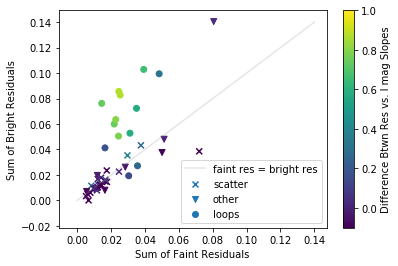

In [194]:
plt.scatter(sfsum,sbsum,marker='x',label='scatter',c=sslopes,vmin=-.1,vmax=1)
plt.scatter(ofsum,obsum,marker='v',label='other',c=oslopes,vmin=-.1,vmax=1)
plt.scatter(lfsum,lbsum,label='loops',c=lslopes,vmin=-.1,vmax=1)
plt.colorbar(label='Difference Btwn Res vs. I mag Slopes')

x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Sum of Bright Residuals')
plt.xlabel('Sum of Faint Residuals')

the slopes and monotonic fractions are both potentially helpful
- so now have four helpful dimensions for separating loopy sources
- may be worth throwing into a PCA

In [212]:
#divide bsum by fsum to collapse dimensions
sdiv = np.array(sbsum)/sfsum #subtraction also works decently
ldiv = np.array(lbsum)/lfsum
odiv = np.array(obsum)/ofsum

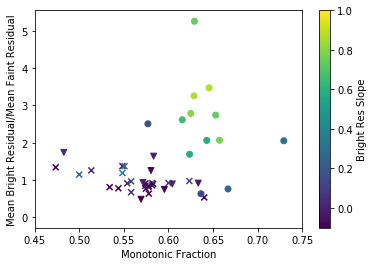

In [218]:
plt.scatter(smfrac,sdiv,marker='x',label='scatter',c=sslopes,vmin=-.1,vmax=1)
plt.scatter(omfrac,odiv,marker='v',label='other',c=oslopes,vmin=-.1,vmax=1)
plt.scatter(lmfrac,ldiv,label='loops',c=lslopes,vmin=-.1,vmax=1)
#cutting out outlier
plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.ylabel('Mean Bright Residual/Mean Faint Residual')
plt.xlabel('Monotonic Fraction')
# plt.savefig('Figs/resfrac_monfrac.png',dpi=150,bbox_inches='tight')

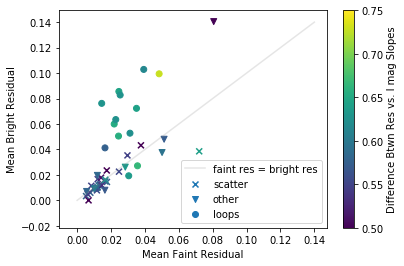

In [219]:
plt.scatter(sfsum,sbsum,marker='x',label='scatter',c=smfrac,vmin=0.5,vmax=0.75)
plt.scatter(ofsum,obsum,marker='v',label='other',c=omfrac,vmin=0.5,vmax=0.75)
plt.scatter(lfsum,lbsum,label='loops',c=lmfrac,vmin=0.5,vmax=0.75)
plt.colorbar(label='Difference Btwn Res vs. I mag Slopes')

x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Mean Bright Residual')
plt.xlabel('Mean Faint Residual')

# plt.savefig('Figs/bright_faint_slopediff.png',dpi=150,bbox_inches='tight')

Text(0.5, 0, 'Mean Faint Residual')

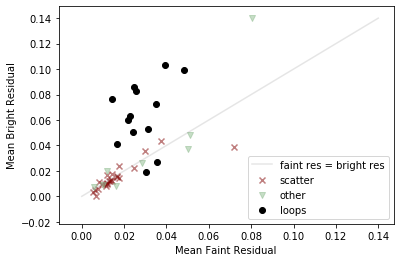

In [217]:
plt.scatter(sfsum,sbsum,color='maroon',marker='x',label='scatter',alpha=0.5)
plt.scatter(ofsum,obsum,color='darkseagreen',marker='v',label='other',alpha=0.5)
plt.scatter(lfsum,lbsum,color='black',label='loops')


x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Mean Bright Residual')
plt.xlabel('Mean Faint Residual')


#### for loops, want dip with color ~black (bright)

I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642


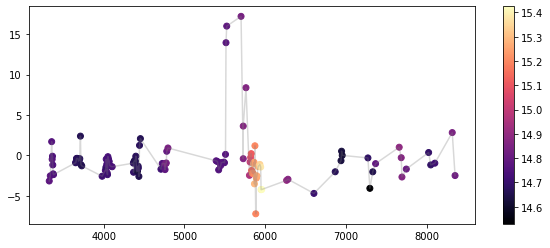

In [85]:
#start outside of function
vband,slopes = colorline(3,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))

plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.28392614544546685
V and V-I correlation: 0.1227097449647219


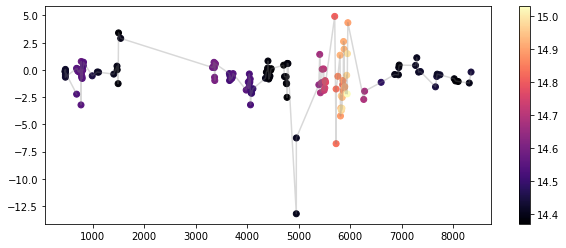

In [84]:
#start outside of function
vband,slopes = colorline(16,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))

plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.9222358982634402
V and V-I correlation: -0.8022991122992864
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383


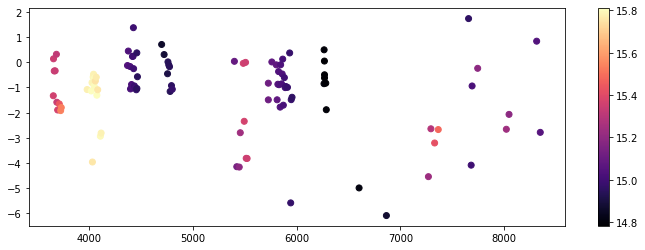

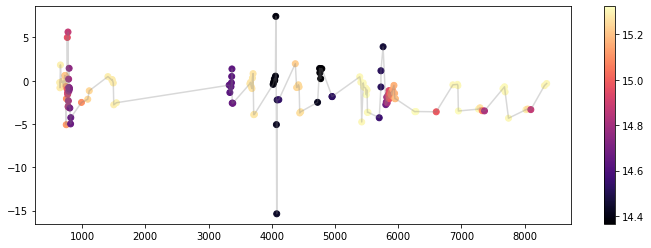

In [83]:
plt.figure(figsize=(12,4))
vband,slopes = colorline(13,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
vband,slopes = colorline(15,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(12,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.9086555042418574
V and V-I correlation: -0.7772043187778405
I and V-I correlation: -0.8678520855167449
V and V-I correlation: -0.7253066994414351


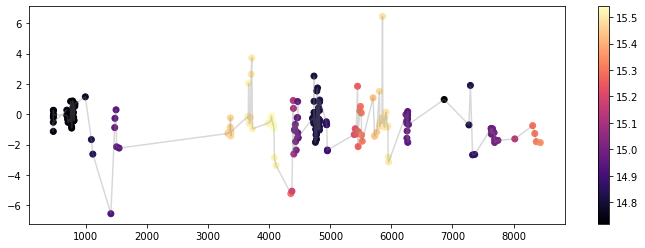

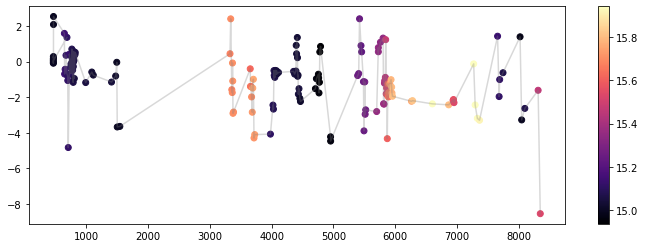

In [82]:
vband,slopes = colorline(27,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(12,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


vband,slopes = colorline(46,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(12,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.6957365004457309
V and V-I correlation: 0.6189396891999773
I and V-I correlation: -0.8744251563223343
V and V-I correlation: -0.7590429450237982


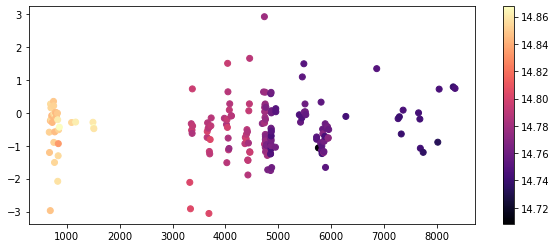

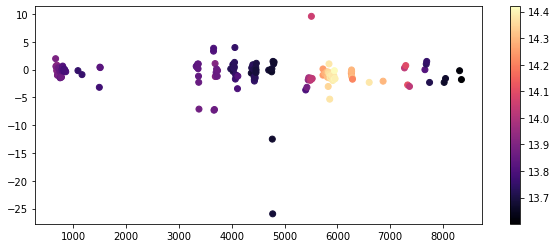

In [34]:
vband,slopes = colorline(38,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()

vband,slopes = colorline(125,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()

#### repeat with vectors rather than 3-point slopes

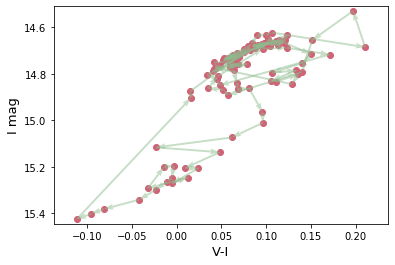

In [79]:
bright,xvect,yvect = colorvec(3,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)

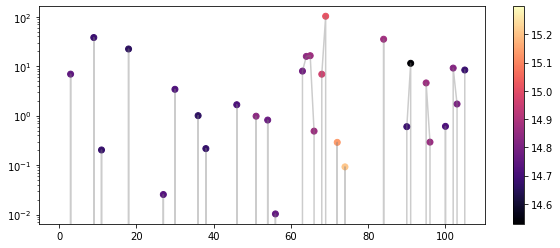

In [81]:
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


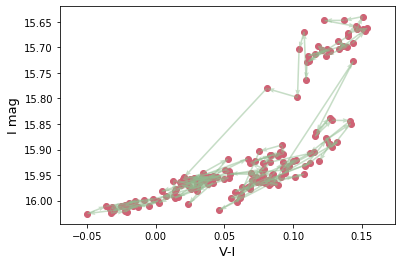

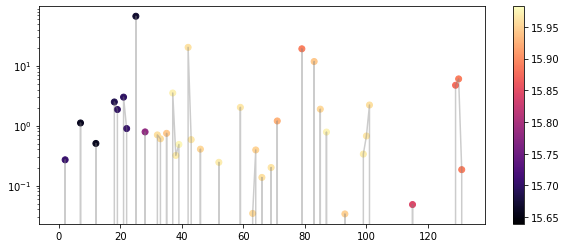

In [76]:
bright,xvect,yvect = colorvec(6,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


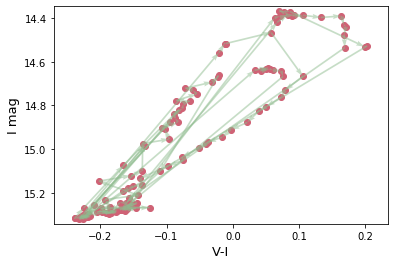

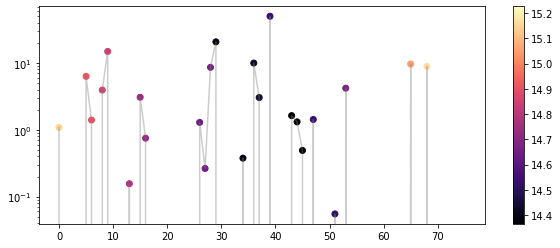

In [75]:
bright,xvect,yvect = colorvec(15,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


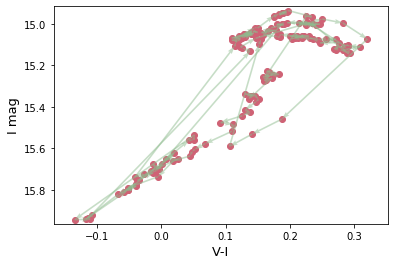

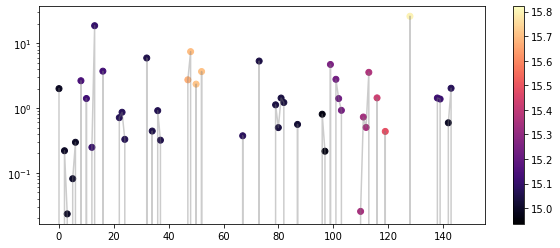

In [74]:
bright,xvect,yvect = colorvec(46,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


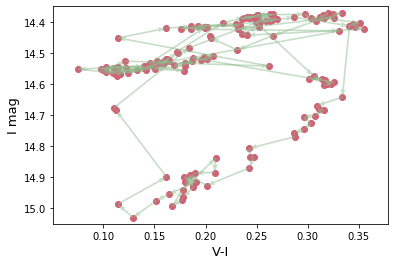

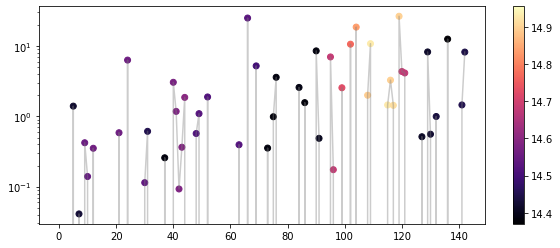

In [73]:
bright,xvect,yvect = colorvec(16,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


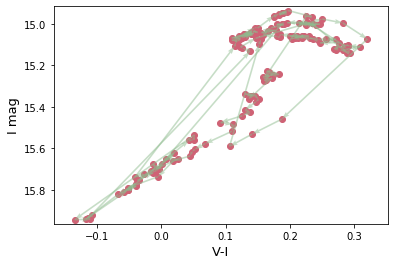

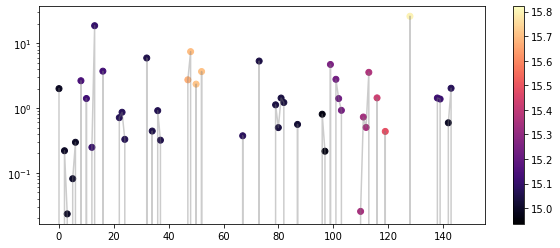

In [72]:
bright,xvect,yvect = colorvec(46,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


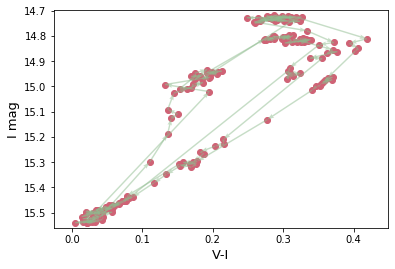

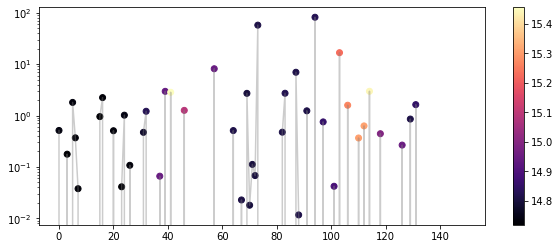

In [71]:
bright,xvect,yvect = colorvec(27,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
#log makes it easier to see if neighbors have similar behavior/correlated
plt.yscale('log')


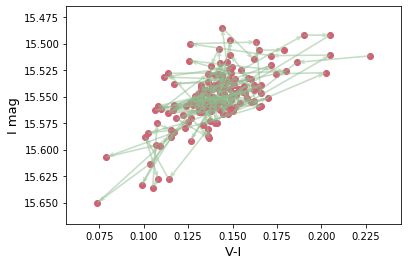

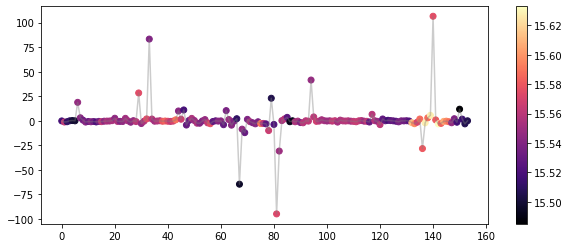

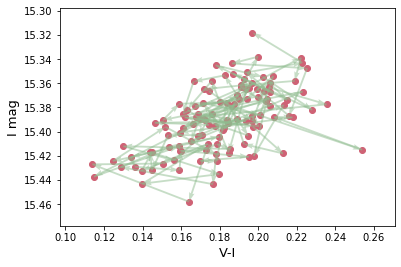

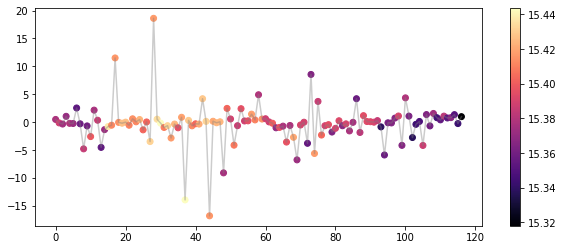

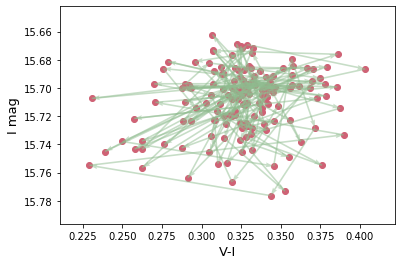

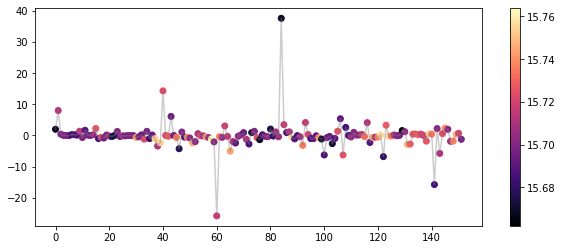

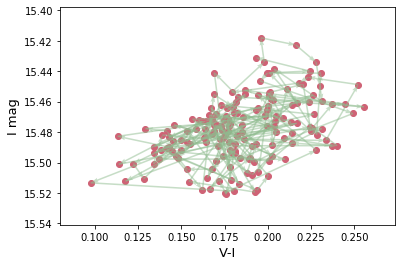

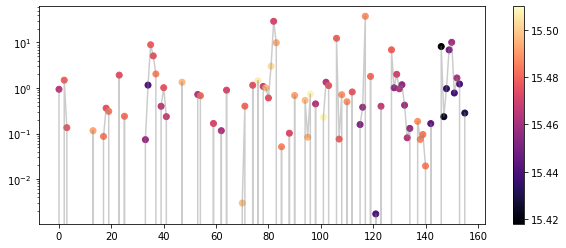

In [70]:
#compare to a couple with high scatter but looks like no loops (but are there?)
bright,xvect,yvect = colorvec(5,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()

bright,xvect,yvect = colorvec(36,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()

bright,xvect,yvect = colorvec(58,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()

bright,xvect,yvect = colorvec(59,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)
plt.yscale('log')
plt.colorbar()

#### these methods don't *look* super promising, but can try saving the outlier magnitude (or as fraction of min or max); slope, and somehow neighbor info
- problem is that there don't appear to be enough neighbor loops

using first 20 sources passed in 


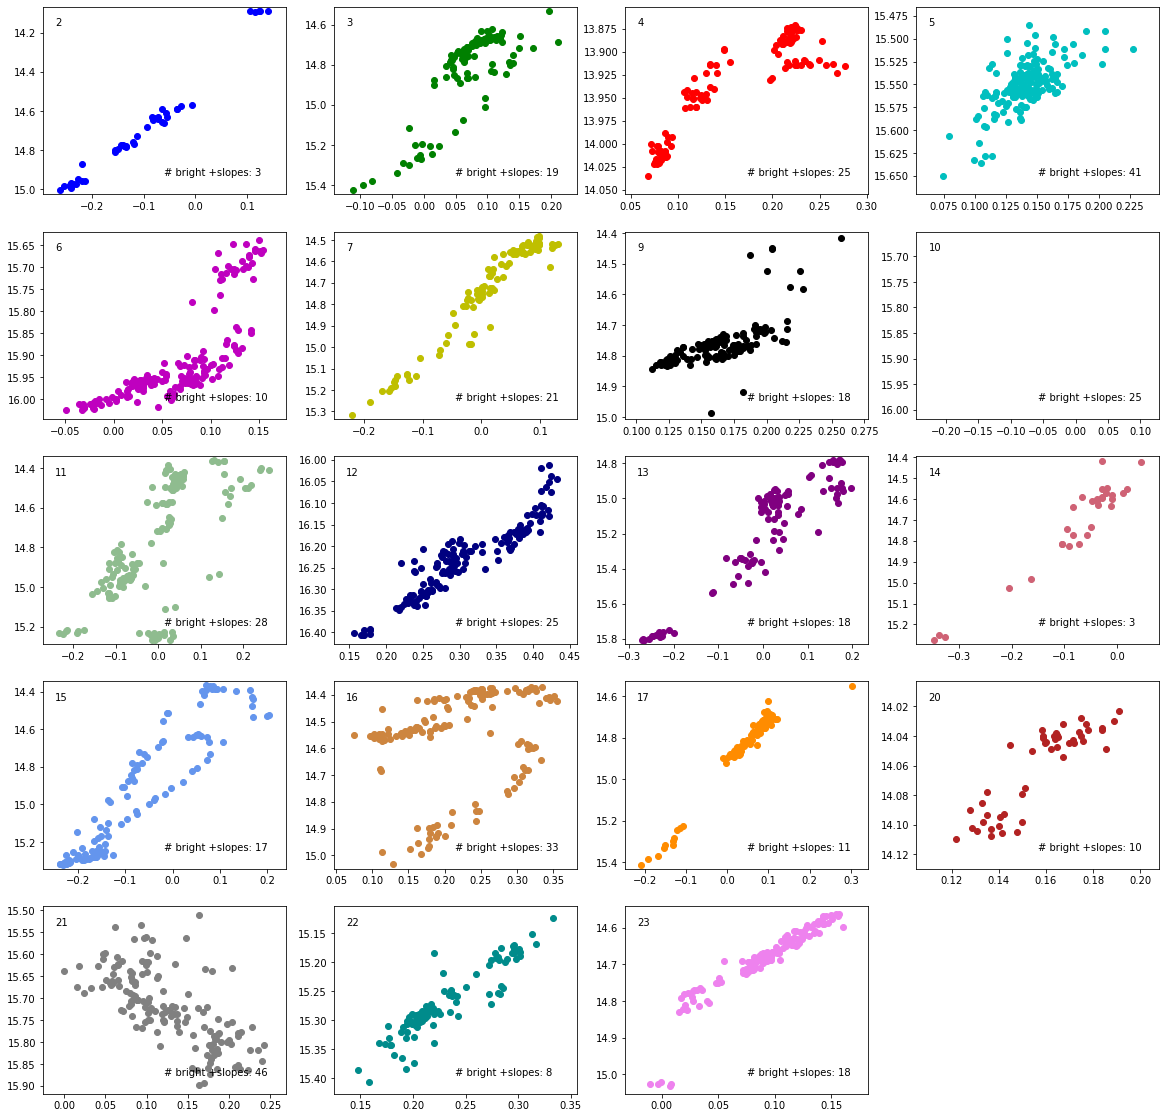

posx and posy should be finite values
posx and posy should be finite values


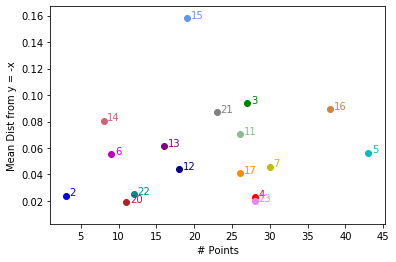

In [18]:
def check_quad(sources):
    '''plots color-mag subplots and mean dist vs. #points fig for up to 20 sources
    sources: source numbers to display
    TO DO: add results from other methods as well'''
    #take first 20 sources if too many passed in
    if len(sources)>20: 
        sources = sources[:20]
        print('using first 20 sources passed in ')
    ocolors = ['darkseagreen','navy','purple',pink,'cornflowerblue','peru','darkorange','firebrick',
              'grey','darkcyan','violet','palegreen','lightsalmon']
    allcols = list(mcolors.BASE_COLORS.keys()) + ocolors
    #initiate lists
    points,dists = [],[]
    fig = plt.figure(figsize=(20,20))
    for s in range(1,len(sources)): #first 20 sources
        ax = fig.add_subplot(5,4,s)
        color = allcols[s-1]
        #get LC 
        try: iband, vband = o.getIV(sources[s-1],cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(sources[s-1],cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,plot=False,printcorr=False)
        #plot colormag
        ax.scatter(vband['V mag']-interp,interp,color=color)
        #annotate with source number
        plt.annotate(str(sources[s-1]), xy=(0.05, 0.9), xycoords='axes fraction')
        #flip y-axis
        maxi,mini = np.max(interp),np.min(interp)
        ax.set_ylim(maxi+.02,mini-.02)
        #get vectors
        npoint, dist = colorvec(sources[s-1],frac=0.5,plotcm=False,plottext=False,plotquad=False,iband=iband,vband=vband,interp=interp)
        points.append(npoint);dists.append(dist)
        #do colorline (fits lines to every three points)
        slopes = colorline(sources[s-1],roll=True,retv=False,hist=False,nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=iband,vband=vband,interp=interp)
        #get positive slopes (bluer when brighter)
        pos_slopes = np.where(slopes>0)
        #get I values for pos slopes
        imags = interp[pos_slopes]
        #include pos slopes that are in brightest quarter 
        irange = maxi-mini
        numpos = len(imags[imags<mini+0.75*irange])
        ax.annotate(f'# bright +slopes: {numpos}',xy=(0.5, 0.1), xycoords='axes fraction')
        #look for loops uisng histogram of residuals from best fit line
        
        #wasn't working well -- occasional error and not giving desired result
        pk,pkind = colorloop(sources[s-1],fracdiff=0.2,diff=2,close=True,iband=iband,vband=vband,interp=interp)
        #annotate based on if there are at least peaks in hist
#         if len(pk)>=2:
#             ax.annotate(f'loop',xy=(0.5, 0.2), xycoords='axes fraction')
#         else: ax.annotate(f'no loop found',xy=(0.5, 0.2), xycoords='axes fraction')
            
    #plot all on new figure
    fig = plt.figure()
    for i in range(len(points)):
        plt.scatter(points[i],dists[i],color=allcols[i])
        #also annotate with srcn
        plt.text(points[i]+0.5,dists[i],str(sources[i]),color=allcols[i])
    plt.xlabel('# Points')
    plt.ylabel('Mean Dist from y = -x') #currently really the sum of mean dists for two quadrants
    return
check_quad(srcns[:23])

**notice source 5 is gets high #points with pos/pos and #points with pos slope at bright values (similar)**
- tried a bit already, but any better way to identify *continuous* rotation?
#### list of loops -- revisit with arrows
- 3

#### potential loops
- 13,4,6 (and these don't stick out on plot very well)
    - these would do better with just looking for higher spread at brighter values
    
#### list of other strange sources to revisit with arrows
- 11,16 (are these "loops"?), 

empty file for OIII I


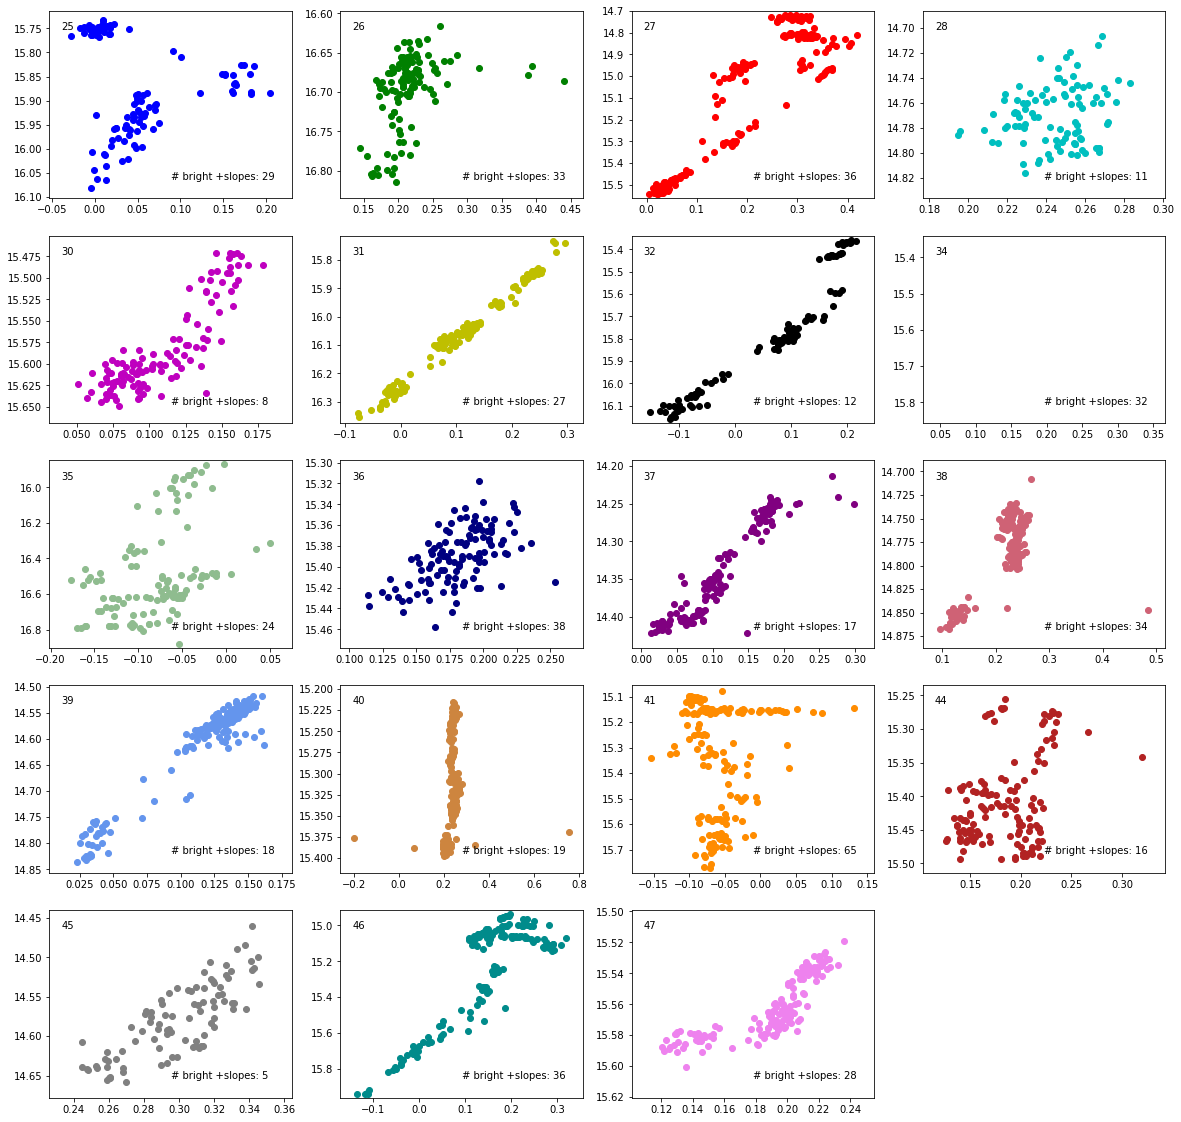

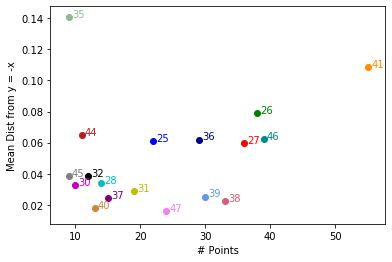

In [19]:
check_quad(srcns[20:40])

#### list of loops -- revisit with arrows
- 3,27

#### potential loops
- 13,4,6 (and these don't stick out on plot very well)
    - these would do better with just looking for higher spread at brighter values
- 46, 25
    
#### list of other strange sources to revisit with arrows
- 11,16 (are these "loops"?)
- 41 (high up on all metrics)
- 35 (only high on dist from y = -x)

In [21]:
#get rid of source #51
srcns = list(srcns)
srcns.remove(51)

In [22]:
srcns.remove(1) #no source

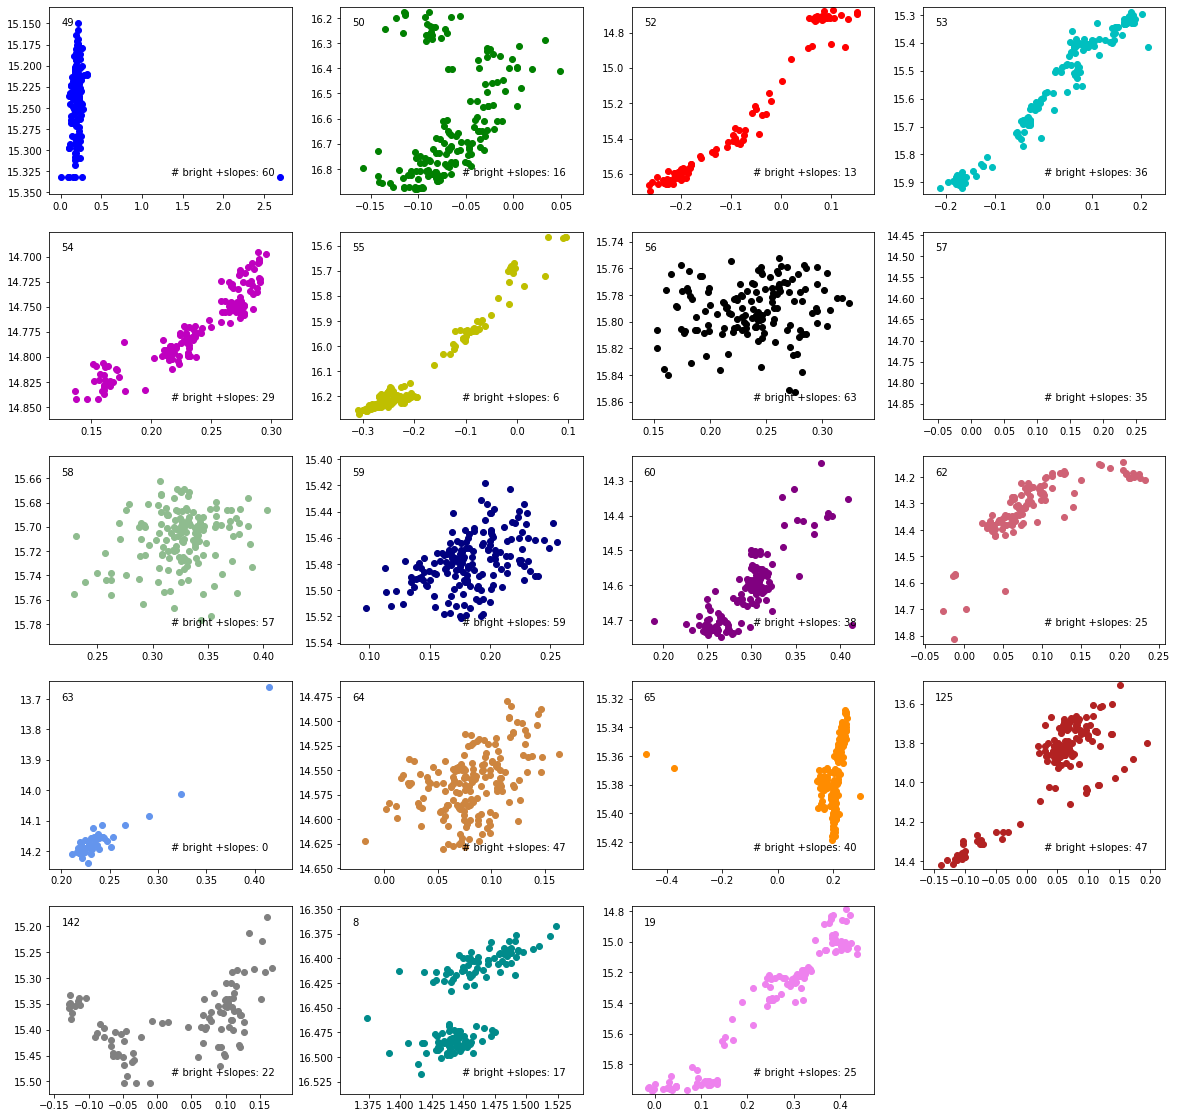

posx and posy should be finite values
posx and posy should be finite values


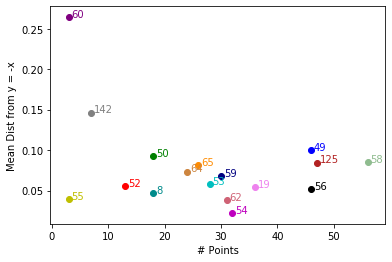

In [23]:
#continuing with next 20 sources (without #51)
check_quad(srcns[40:60])

to do: check why some not plotted (e.g. src #57)

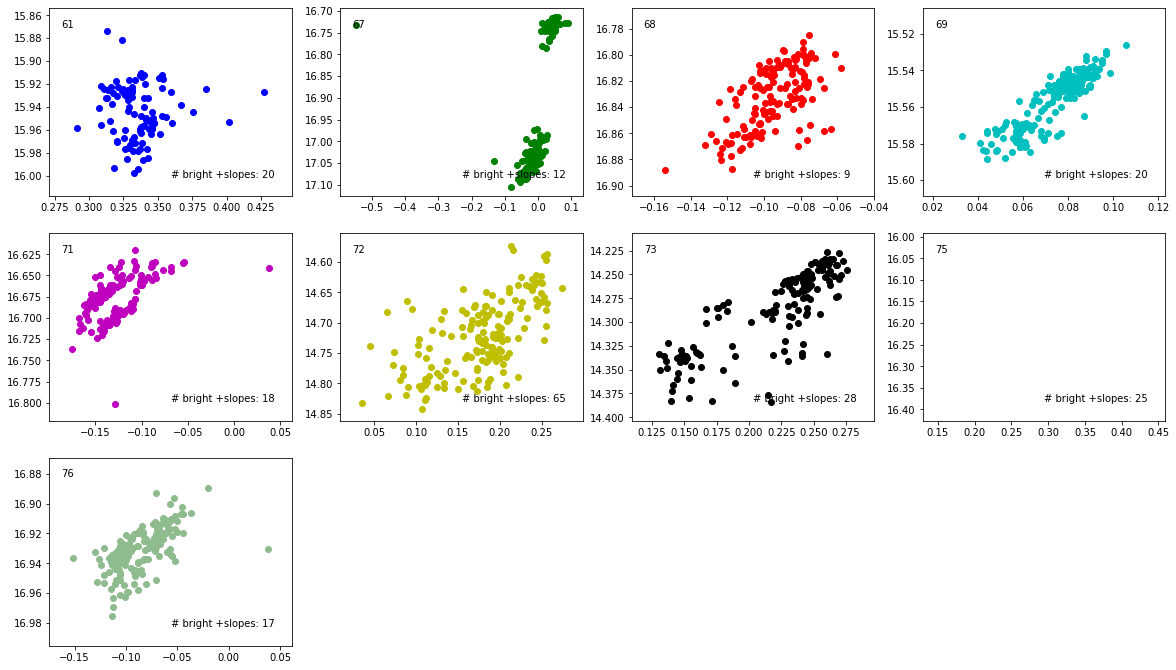

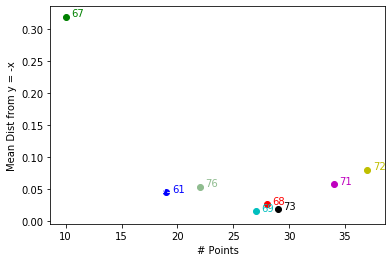

In [26]:
check_quad(srcns[60:70])

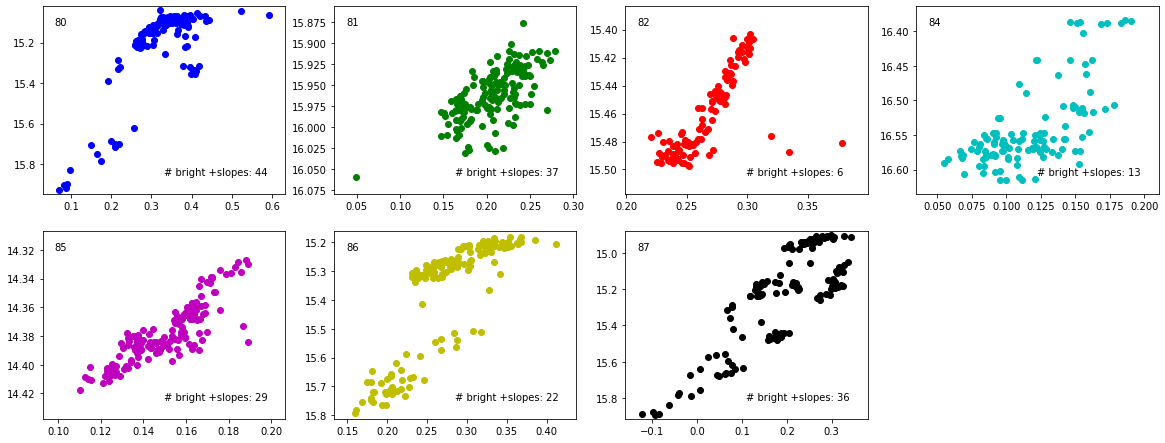

posx and posy should be finite values
posx and posy should be finite values


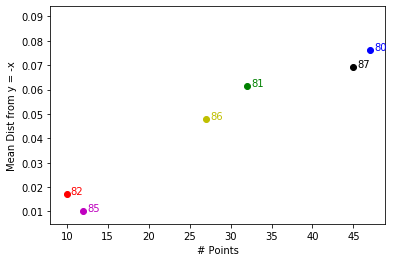

In [28]:
check_quad(srcns[72:80])

empty file for OIII I


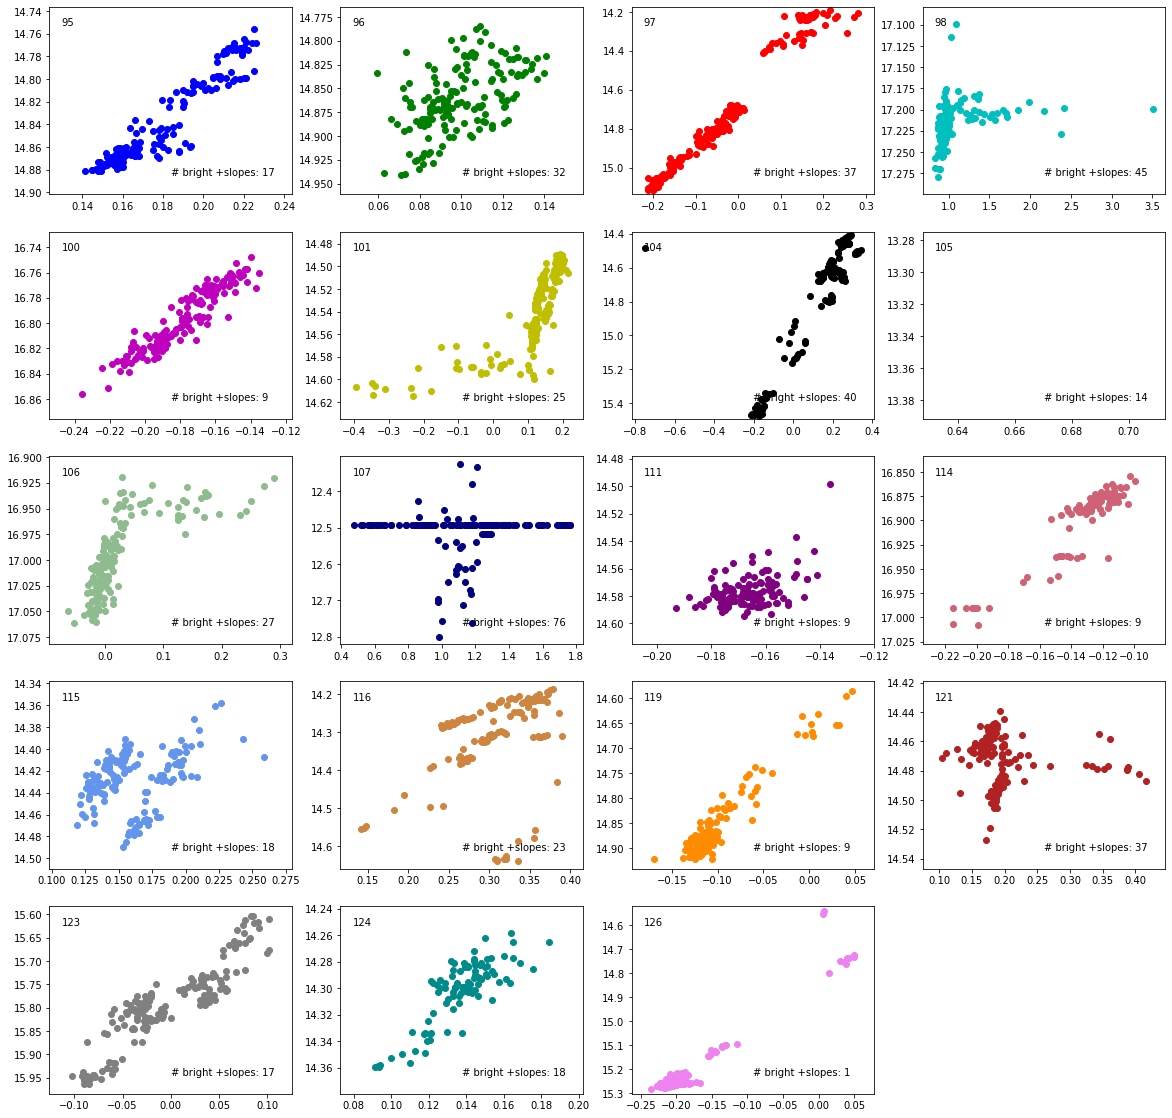

posx and posy should be finite values
posx and posy should be finite values


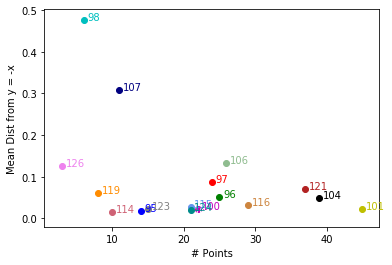

In [29]:
check_quad(srcns[80:100])

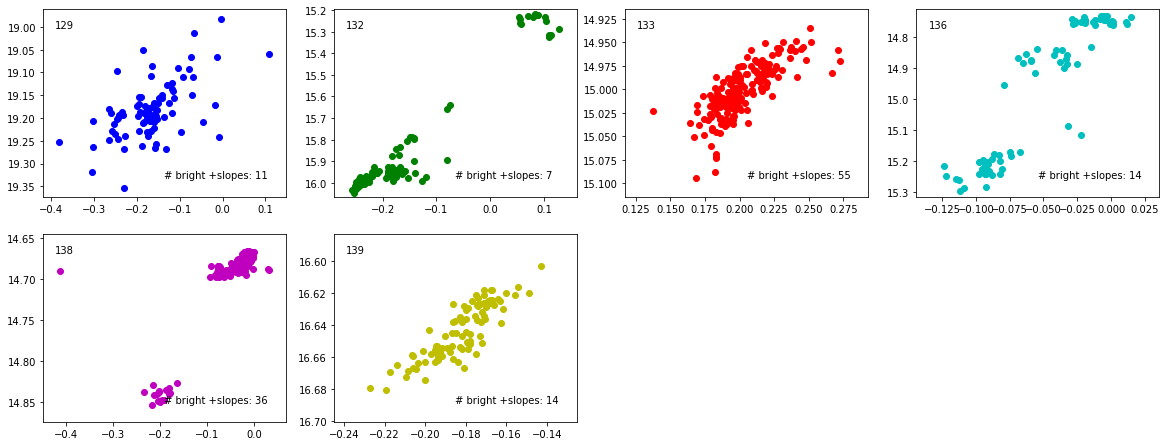

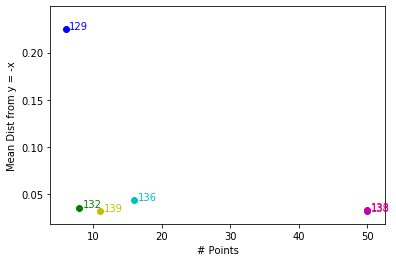

In [30]:
check_quad(srcns[100:])